---

# Unsupervised Machine Learning Approach
## Methodology:  DBSCAN Iteration and Tuning
###  Univariate Temperature Data
---

<br>

**READ**  -  I've created a python script to allow the user to click the button and then they can either have all of the underyling code shown, OR they can just look at the raw output (charts, plots, whatever).  
As you know, sometimes these notebooks contain a fair amount of code... and sometimes folks just want the _results_... here is an [example](https://nbviewer.jupyter.org/urls/gist.github.com/masnick/d6a1af14812c0c4b3314/raw/f7a5abfb6475e683a90b4ac3491d134ef604e460/test.ipynb)

Code defaults to NOT showing any code, so click the toggle button to view the show the underlying code...

In [1]:
# %load toggle.py
# allows code to be hidden, unhidden on jupyter notebook
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide All Notebook Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show All Notebook Code"></form>''')

```Import standard python libraries```

In [2]:
import warnings
warnings.filterwarnings("ignore")
# import matplotlib.cbook
# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import pickle
import datetime
import multiprocessing as mp
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')
# default start, but later you can change if you desire 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

```Move directories to read in file```

In [3]:
%cd D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION\

D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION


```Read in data (parquet saved and exported file from previous notebook```

In [4]:
# tsys01 sensor temp values
import fastparquet
pf = pd.read_parquet('tsys.parquet', engine='fastparquet')

```Convert temperature variable from C to F```

In [5]:
# F = C×(9/5)+32
pf['value_hrf'] = pf['value_hrf'].apply(lambda x: (9/5)*x + 32)

In [6]:
pf.head(10)

sensor    parameter  value_hrf
timestamp                                          
2019-01-01 00:00:03  tsys01  temperature     40.640
2019-01-01 00:00:28  tsys01  temperature     40.496
2019-01-01 00:00:53  tsys01  temperature     40.406
2019-01-01 00:01:18  tsys01  temperature     40.424
2019-01-01 00:01:43  tsys01  temperature     40.478
2019-01-01 00:02:08  tsys01  temperature     40.424
2019-01-01 00:02:33  tsys01  temperature     40.334
2019-01-01 00:02:58  tsys01  temperature     40.496
2019-01-01 00:03:23  tsys01  temperature     40.424
2019-01-01 00:03:48  tsys01  temperature     40.352

In [7]:
pf.tail(10)

sensor    parameter  value_hrf
timestamp                                          
2019-02-28 23:56:10  tsys01  temperature     31.766
2019-02-28 23:56:35  tsys01  temperature     31.946
2019-02-28 23:57:00  tsys01  temperature     32.018
2019-02-28 23:57:25  tsys01  temperature     31.820
2019-02-28 23:57:50  tsys01  temperature     31.784
2019-02-28 23:58:15  tsys01  temperature     31.946
2019-02-28 23:58:40  tsys01  temperature     32.270
2019-02-28 23:59:05  tsys01  temperature     32.144
2019-02-28 23:59:30  tsys01  temperature     32.090
2019-02-28 23:59:55  tsys01  temperature     31.640

In [8]:
print('\nNumber of rows of data ........', f'{len(pf):,}')


Number of rows of data ........ 203,481


In [9]:
# date range
print('\nStart .....', pf.head(1).index[0])
print('\nEnd .......', pf.tail(1).index[0])


Start ..... 2019-01-01 00:00:03

End ....... 2019-02-28 23:59:55


---

In [10]:
tsys = pf.copy()
# look at notebook 201, we filtered all the way to 
# tsys01 level, my imported data (parquet) already
# assumes that was all done, so for clarity, renaming
# pf to the tsys equivalent from 201...

In [11]:
%cd D:\GITHUB_Repos\SensorAnalysis\ENTER\results

D:\GITHUB_Repos\SensorAnalysis\ENTER\results


```Plotting our raw temperature data to see what it looks like```

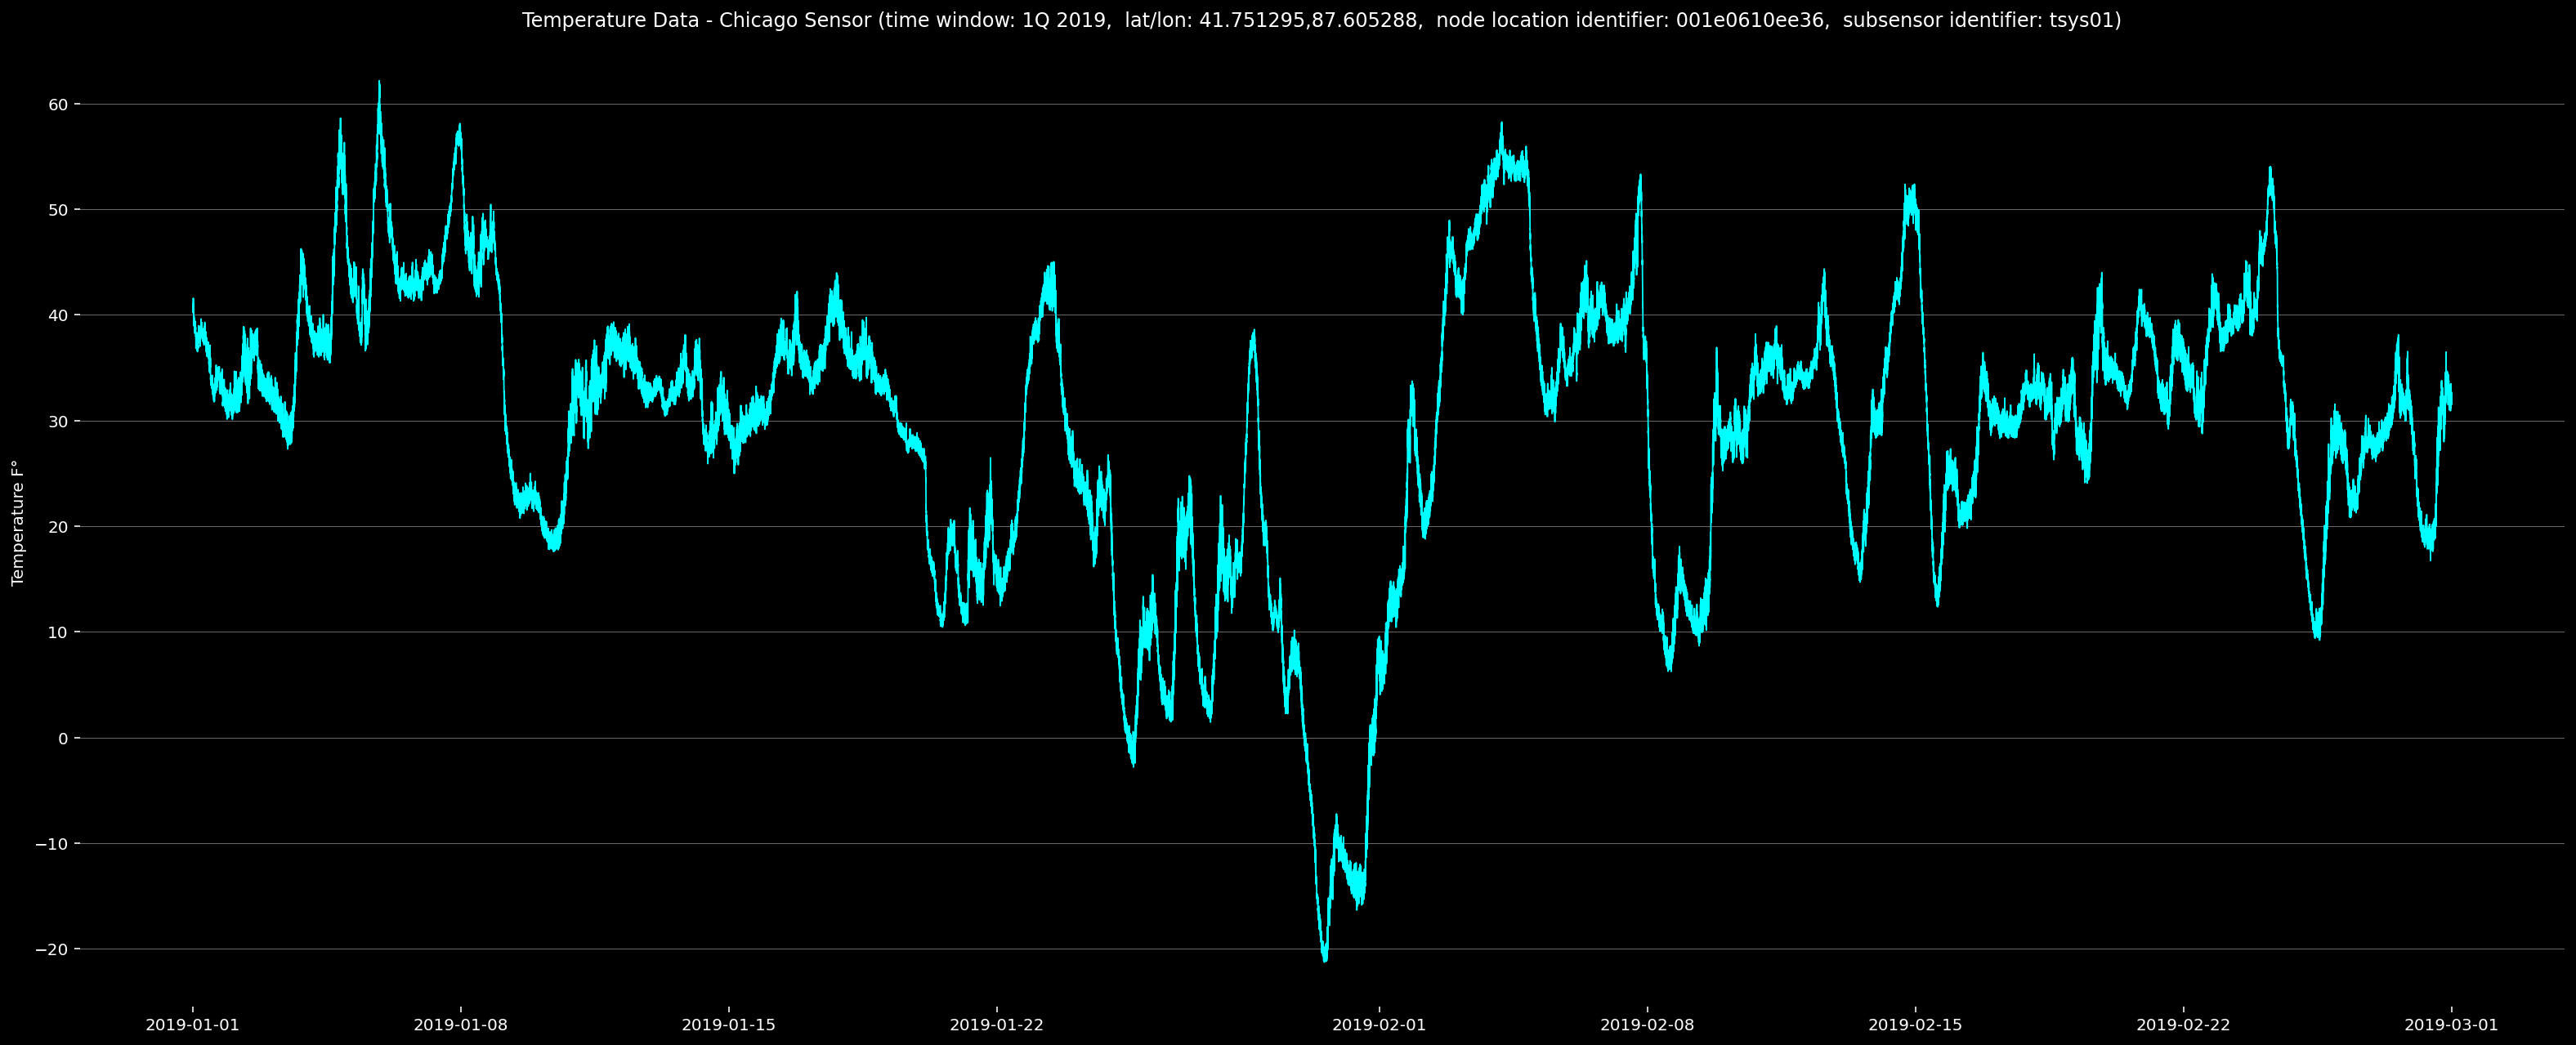

In [12]:
plt.figure(figsize=(22, 9))
plt.plot(tsys.index, tsys.value_hrf, 'cyan', markersize=1, linewidth=.9, label="temp sensor")
plt.ylabel('Temperature F°')
plt.box(False)
plt.title(r'Temperature Data - Chicago Sensor (time window: 1Q 2019,  lat/lon: 41.751295,87.605288,  node location identifier: 001e0610ee36,  subsensor identifier: tsys01)')
plt.grid(axis='y', color='grey', linestyle='-', linewidth=.5, alpha=.8)
plt.locator_params(axis='y', nbins=10)
plt.tight_layout()
plt.show();
# plt.savefig('single_subsensor_temp_data_plotted_two_months.png', dpi=600)

```Converting raw data via StandardScaler()```

In [13]:
tsys.columns

Index(['sensor', 'parameter', 'value_hrf'], dtype='object')

In [14]:
# PYTHONIC: kill a column IF it exits already 
# (so no warning/errrors stopping us)
thisFilter = tsys.filter('cluster')
tsys.drop(thisFilter, inplace=True, axis=1)
# tsys.drop('cluster', axis=1, inplace=True)  
# if you iterate, you need to remove ! 

In [15]:
tsys.columns.values

array(['sensor', 'parameter', 'value_hrf'], dtype=object)

In [16]:
X = tsys['value_hrf'].copy()
# X[:10]
# X.values[:10]
# Utilize standard scaler 
X = StandardScaler().fit_transform(X.values.reshape(-1,1))

Standard Scaler View of Data (normalized):


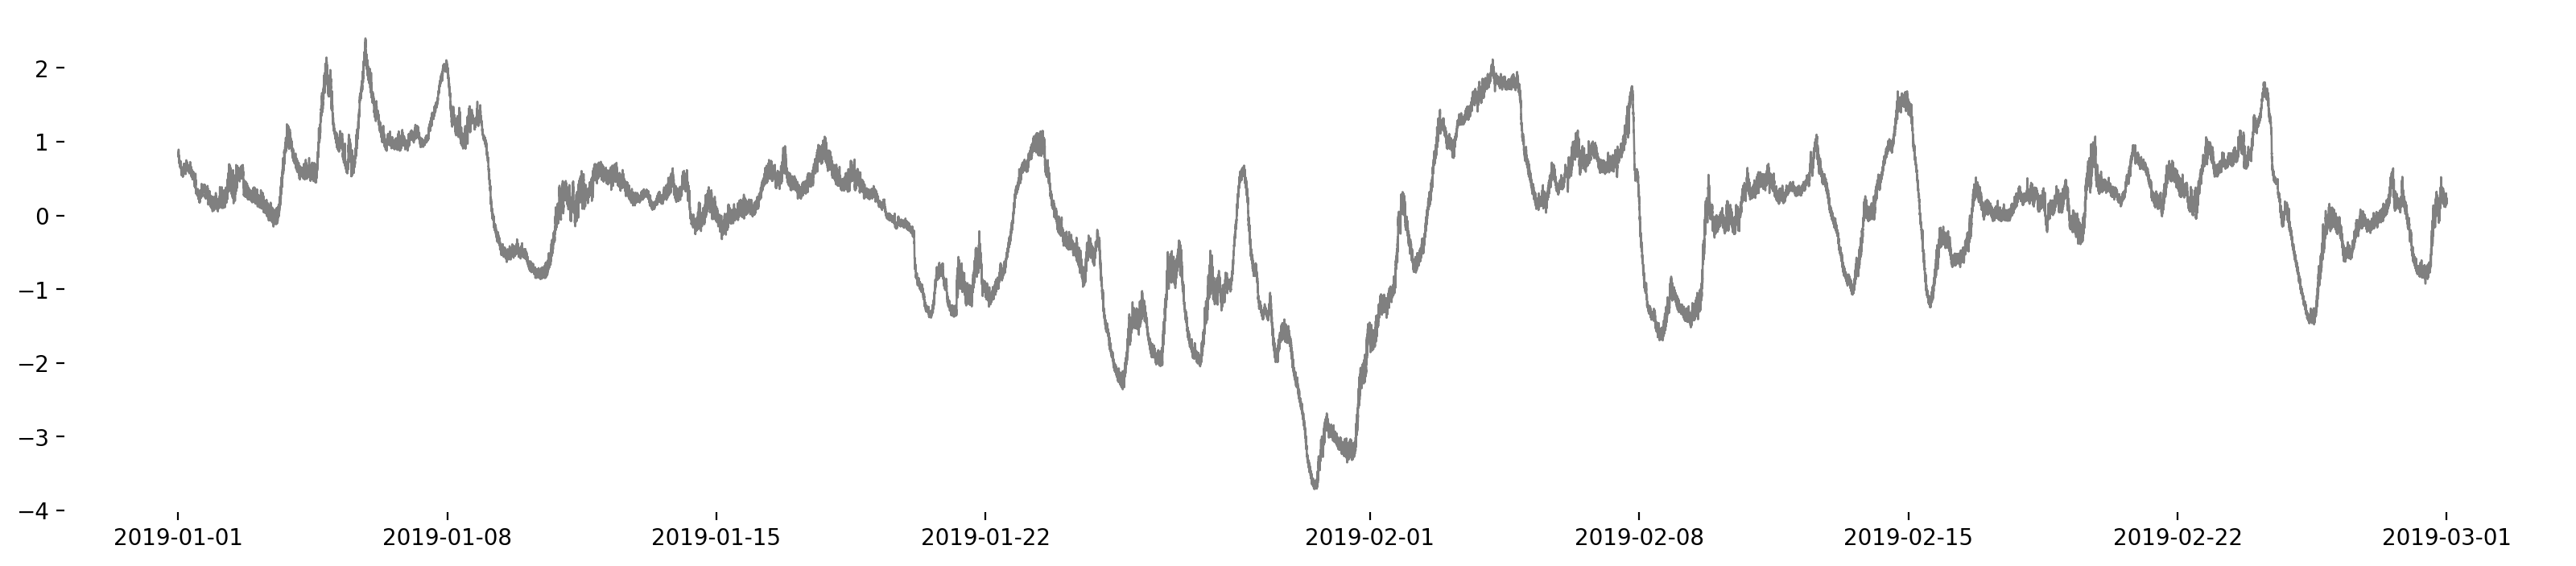

In [17]:
plt.style.use('default')
plt.figure(figsize=(20, 4))
plt.plot(tsys.index, X, 'grey', markersize=1, linewidth=.9)
plt.box(False)
print("Standard Scaler View of Data (normalized):")
plt.show();
# normalized 

STOP and think:
 - I need a gridsearch type method for my dbscan eps/min_samples to determine the repercussion to cluster size and count, what is pertinent and what isn't, and generalized behavior as eps/min_samples variables fluctuate

---

##  Assimilated Observations:

1. As min_samples value increases, in general the number of 
   Cluster -1 anomalies appears to increase, but not dramatically 
   
2. eps value of 0.01 appears (in my estimation) to be HIGH of a value !  

3. The larger that eps value gets, the LONGER it takes to process mathematically and thus compute wise ! 

4. Definitions:
    eps: Two points are considered neighbors if the distance between the two points is below the threshold epsilon.
    min_samples: The minimum number of neighbors a given point should have in order to be classified as a core point. It’s     
    important to note that the point itself is included in the minimum number of samples.
    metric: The metric to use when calculating distance between instances in a feature array (i.e. euclidean distance).
    
5. As the number of min_samples increase, in theory the cluster counts found should decrease...


6. As the number of min_samples (for a set eps value) increases, the NUMBER of cluster -1 matches will increase...

    
    


---

```-- DBSCAN Gridsearch 1 --
       Running DBSCAN on the raw data and varying eps/min_samples hyperparameters to determine outcome```

In [18]:
# UNUSUAL:
# IT RUNS FASTER ! 

#### I previously ran this...

In [19]:
# careful, make sure you remove the sys.stdout or you won't see anything 
# later ! ! ! 

```python

import sys

# THIS IS REALLY CHECKING A HUGE MUMBER OF VARIATIONS...

eps_range = [.02]

# , .02, .03, .04, .05, .06, .07, .08, 
#              .09, .10, .11, .12, .13, .14, .15, .16, 
#              .17, .18, .19, .20]

min_samples_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 
                     12, 13, 14, 15, 16, 17, 18, 
                     19, 20, 21, 22, 23, 24, 25]

sys.stdout = open('D:\dbscan_gridsearch_02.txt','wt')

print('Tom Bresee:')
print('')
print('eps range:')
print(eps_range)
print('')
print('min_samples range:')
print(min_samples_range)
print('')

for i in eps_range:
    for j in min_samples_range:
        print('--- NEW VARIABLE ---')
        db = DBSCAN(eps=i, min_samples=j, metric='euclidean', n_jobs=-1).fit(X)
        label=db.labels_
        sample_cores=np.zeros_like(label,dtype=bool)
        sample_cores[db.core_sample_indices_]=True
        n_clusters=len(set(label))- (1 if -1 in label else 0)
        print('eps:', i, "  min_samples:", j)
        print('Cluster Count:',n_clusters)
        tsys["cluster"] = db.labels_
        print(tsys["cluster"].value_counts(), '\n')
        print("")
        
 ```

In [20]:

# import sys

# # THIS IS REALLY CHECKING A HUGE MUMBER OF VARIATIONS...

# eps_range = [.02]

# # , .02, .03, .04, .05, .06, .07, .08, 
# #              .09, .10, .11, .12, .13, .14, .15, .16, 
# #              .17, .18, .19, .20]

# min_samples_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 
#                      12, 13, 14, 15, 16, 17, 18, 
#                      19, 20, 21, 22, 23, 24, 25]

# sys.stdout = open('D:\dbscan_gridsearch_02.txt','wt')

# print('Tom Bresee:')
# print('')
# print('eps range:')
# print(eps_range)
# print('')
# print('min_samples range:')
# print(min_samples_range)
# print('')

# for i in eps_range:
#     for j in min_samples_range:
#         print('--- NEW VARIABLE ---')
#         db = DBSCAN(eps=i, min_samples=j, metric='euclidean', n_jobs=-1).fit(X)
#         label=db.labels_
#         sample_cores=np.zeros_like(label,dtype=bool)
#         sample_cores[db.core_sample_indices_]=True
#         n_clusters=len(set(label))- (1 if -1 in label else 0)
#         print('eps:', i, "  min_samples:", j)
#         print('Cluster Count:',n_clusters)
#         tsys["cluster"] = db.labels_
#         print(tsys["cluster"].value_counts(), '\n')
#         print("")
        

```

Output:
Tom Bresee:

eps range:
[0.01]

min_samples range:
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


--- NEW VARIABLE ---
eps: 0.01   min_samples: 3
Cluster Count: 3
0    203424
1        54
2         3
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 4
Cluster Count: 2
 0    203424
 1        54
-1         3
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 5
Cluster Count: 2
 0    203424
 1        54
-1         3
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 6
Cluster Count: 2
 0    203424
 1        54
-1         3
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 7
Cluster Count: 2
 0    203423
 1        54
-1         4
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 8
Cluster Count: 3
 0    203423
 1        47
 2         6
-1         5
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 9
Cluster Count: 4
 0    203354
 1        69
 2        39
-1        13
 3         6
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 10
Cluster Count: 3
 0    203354
 1        69
 2        31
-1        27
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 11
Cluster Count: 3
 0    203354
 1        69
-1        34
 2        24
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 12
Cluster Count: 3
 0    203354
 1        69
-1        34
 2        24
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 13
Cluster Count: 5
 0    198366
 4      4988
 1        69
-1        34
 2        13
 3        11
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 14
Cluster Count: 3
 0    198366
 2      4988
 1        69
-1        58
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 15
Cluster Count: 3
 0    198366
 2      4988
-1        64
 1        63
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 16
Cluster Count: 4
 0    198365
 3      4988
-1        73
 1        34
 2        21
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 17
Cluster Count: 4
 0    198362
 3      4991
-1        73
 1        31
 2        24
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 18
Cluster Count: 4
 0    198361
 3      4990
-1        80
 1        27
 2        23
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 19
Cluster Count: 4
 0    198361
 3      4988
-1        85
 1        26
 2        21
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 20
Cluster Count: 3
 0    198361
 2      4988
-1       107
 1        25
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 21
Cluster Count: 3
 0    198358
 2      4986
-1       116
 1        21
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 22
Cluster Count: 2
 0    198357
 1      4986
-1       138
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 23
Cluster Count: 2
 0    198357
 1      4986
-1       138
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 24
Cluster Count: 2
 0    198357
 1      4986
-1       138
 


--- NEW VARIABLE ---
eps: 0.01   min_samples: 25
Cluster Count: 4
 0    198355
 3      4943
-1       141
 1        30
 2        12
 
```


In [21]:
# i think eps of 0.1 is WAY TOO BIG 

```

Tom Bresee:

eps range:
[0.02]    < - - - - EPS way too big i believe ! 

min_samples range:
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

--- NEW VARIABLE ---
eps: 0.02   min_samples: 3
Cluster Count: 1
0    203481
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 4
Cluster Count: 1
0    203481
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 5
Cluster Count: 1
0    203481
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 6
Cluster Count: 1
0    203481
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 7
Cluster Count: 1
0    203481
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 8
Cluster Count: 1
 0    203480
-1         1
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 9
Cluster Count: 1
 0    203480
-1         1
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 10
Cluster Count: 1
 0    203480
-1         1
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 11
Cluster Count: 1
 0    203479
-1         2
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 12
Cluster Count: 1
 0    203479
-1         2
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 13
Cluster Count: 2
 0    203425
 1        53
-1         3
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 14
Cluster Count: 2
 0    203425
 1        53
-1         3
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 15
Cluster Count: 2
 0    203425
 1        53
-1         3
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 16
Cluster Count: 2
 0    203425
 1        53
-1         3
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 17
Cluster Count: 2
 0    203425
 1        52
-1         4
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 18
Cluster Count: 2
 0    203424
 1        47
-1        10
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 19
Cluster Count: 2
 0    203424
 1        44
-1        13
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 20
Cluster Count: 2
 0    203424
 1        42
-1        15
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 21
Cluster Count: 2
 0    203424
 1        42
-1        15
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 22
Cluster Count: 2
 0    203424
 1        33
-1        24
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 23
Cluster Count: 2
 0    203424
 1        33
-1        24
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 24
Cluster Count: 2
 0    203424
 1        30
-1        27
Name: cluster, dtype: int64 


--- NEW VARIABLE ---
eps: 0.02   min_samples: 25
Cluster Count: 2
 0    203424
-1        31
 1        26
Name: cluster, dtype: int64 

```

In [22]:

# eps_range = [.003]

# min_samples_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 
#                      12, 13, 14, 15, 16, 17, 18, 
#                      19, 20, 21, 22, 23, 24, 25, 50, 100, 150]

# sys.stdout = open('D:\dbscan_gridsearch_04.txt','wt')

# print('')
# print('eps range:')
# print(eps_range)
# print('')
# print('min_samples range:')
# print(min_samples_range)
# print('')

# for i in eps_range:
#     for j in min_samples_range:
#         print('--- NEW VARIABLE ---')
#         db = DBSCAN(eps=i, min_samples=j, metric='euclidean', n_jobs=-1).fit(X)
#         label=db.labels_
#         sample_cores=np.zeros_like(label,dtype=bool)
#         sample_cores[db.core_sample_indices_]=True
#         n_clusters=len(set(label))- (1 if -1 in label else 0)
#         print('eps:', i, "  min_samples:", j)
#         print('Cluster Count:',n_clusters)
        
#         tsys["cluster"] = db.labels_
#         print(tsys["cluster"].value_counts(), '\n')
#         print("")
        

##  Tuning

```ASSUME:  min_samples: 40```

In [23]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

After I selected my MinPts value, I used NearestNeighbors from Scikit-learn, documentation here, to calculate the average distance between each point and its n_neighbors. The one parameter you need to define is n_neighbors, which in this case is the value you choose for MinPts.

Calculate the average distance between each point in the data set and its 40 nearest neighbors (my selected MinPts value)

In [24]:
neighbors = NearestNeighbors(n_neighbors=40)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

In [25]:
# distances

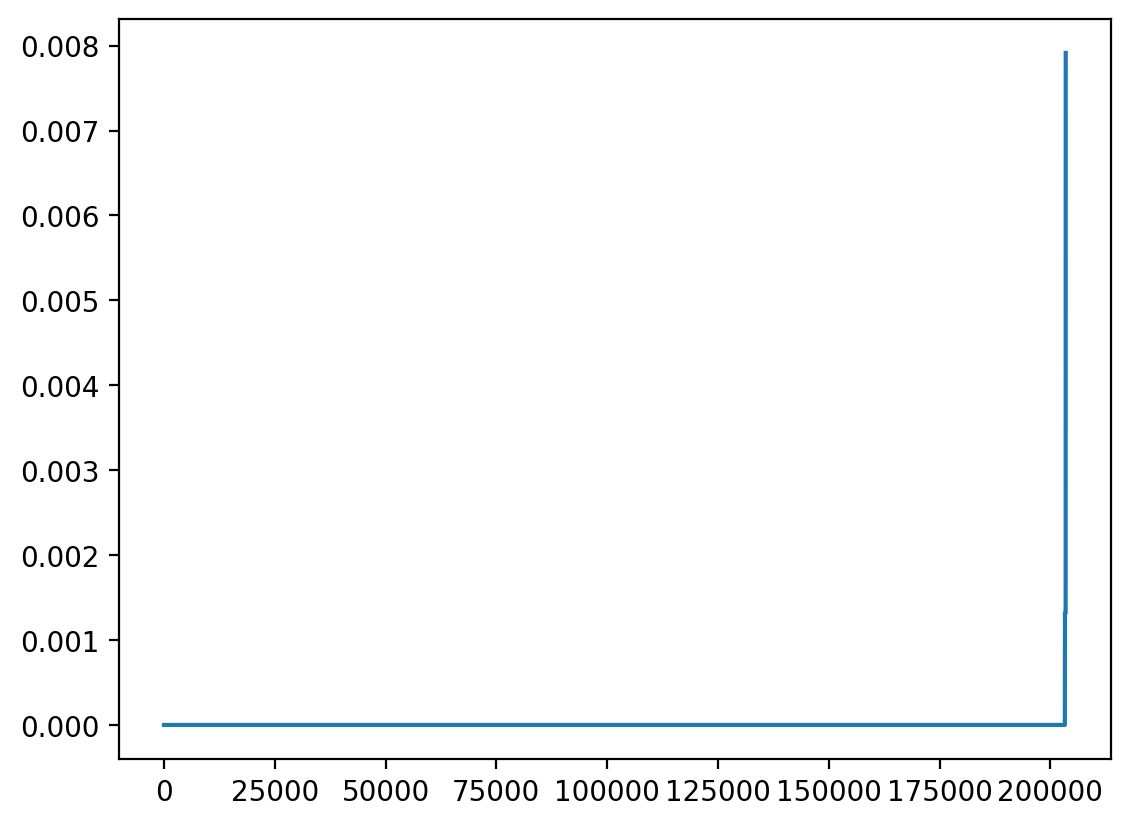

In [26]:
distances = np.sort(distances, axis=0)
#dist4 = distances[:3]
#dist10 = distances[:9]
distances = distances[:,1]
plt.plot(distances); 
# plt.plot(dist4)

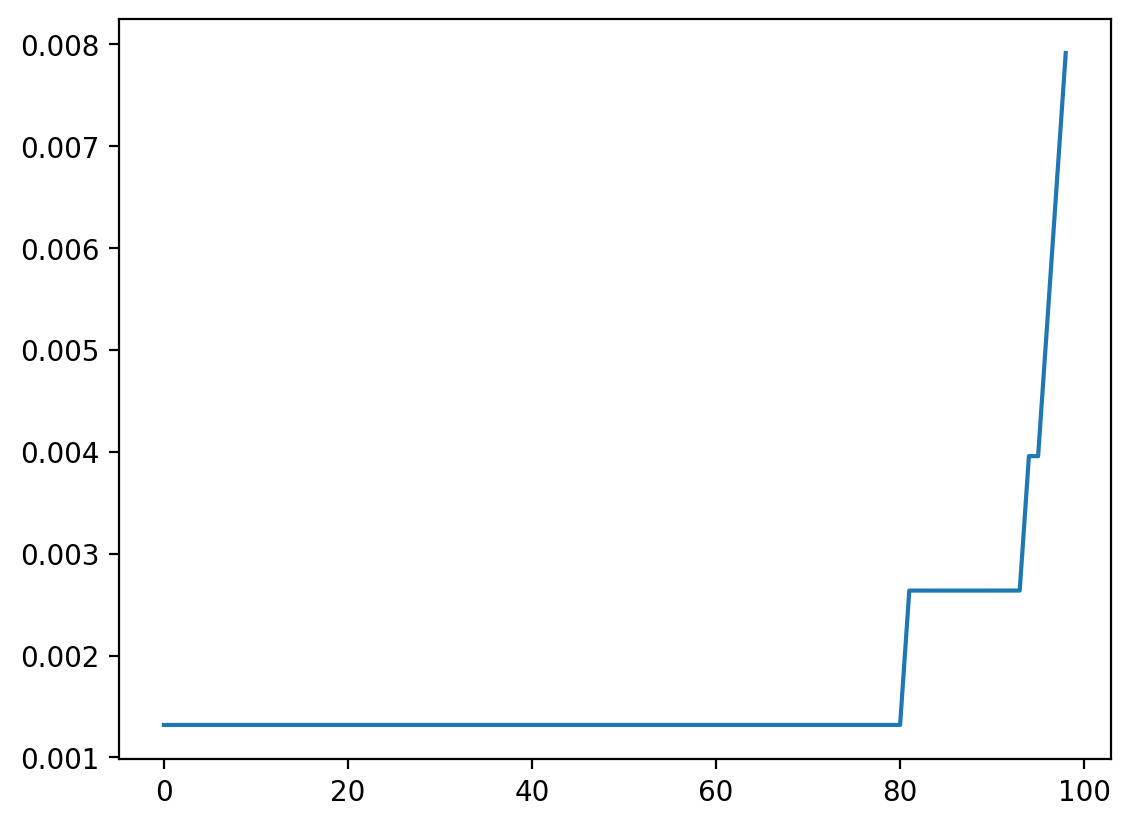

In [27]:
plt.plot(distances[-100:-1])
plt.show(); 

```ASSUME:  min_samples: 50```

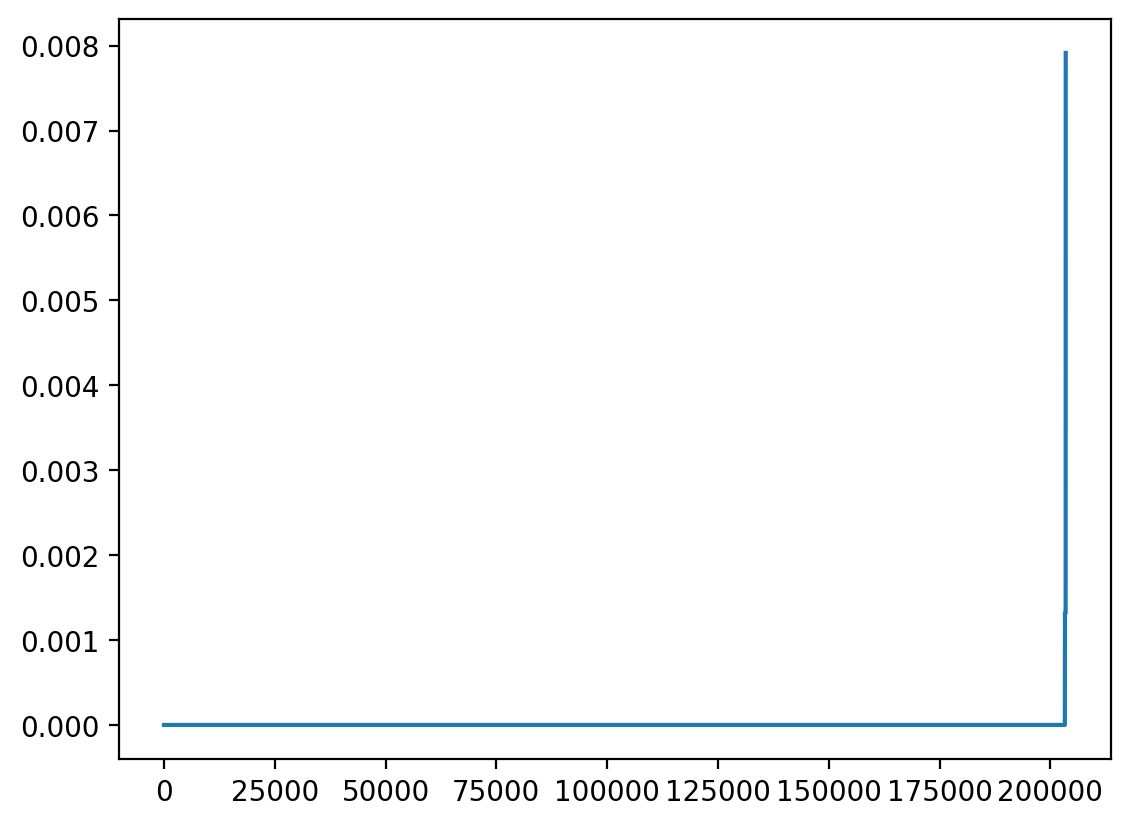

In [28]:
neighbors = NearestNeighbors(n_neighbors=50)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
#dist4 = distances[:3]
#dist10 = distances[:9]
distances = distances[:,1]
plt.plot(distances); 
# plt.plot(dist4)

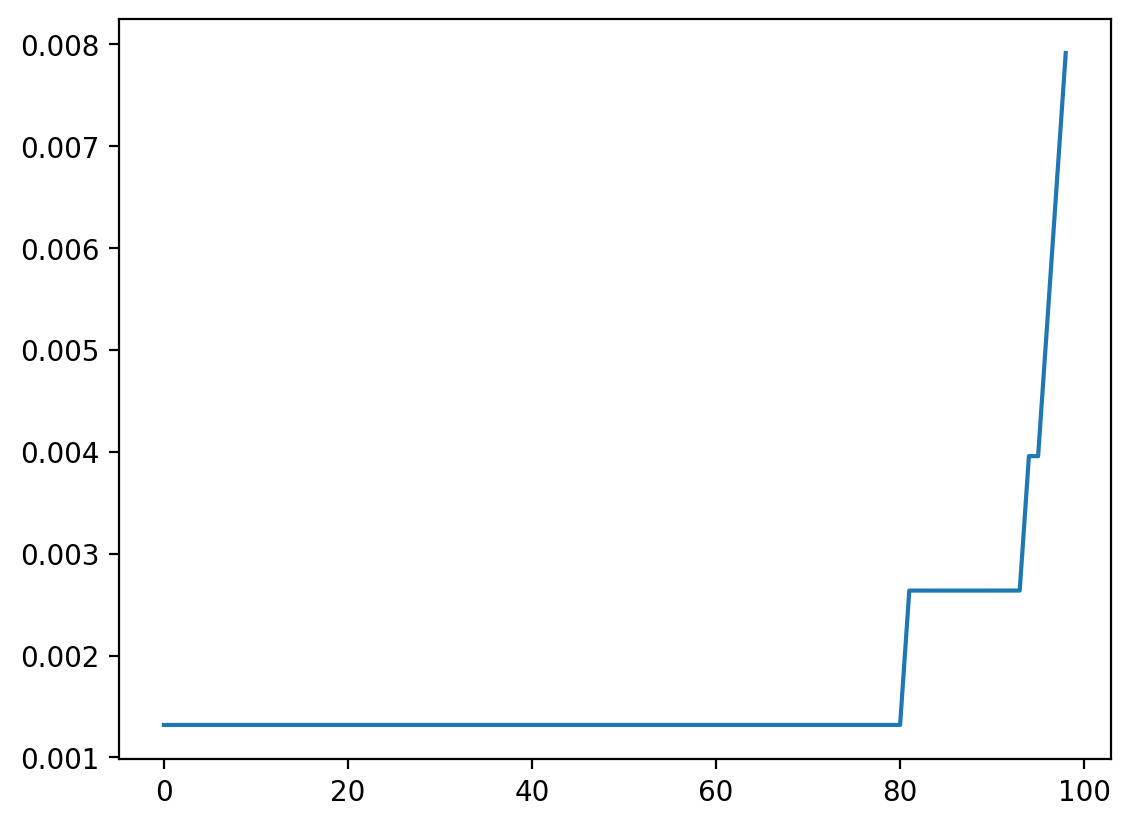

In [29]:
plt.plot(distances[-100:-1])
plt.show(); 

```ASSUME:  min_samples: 100```

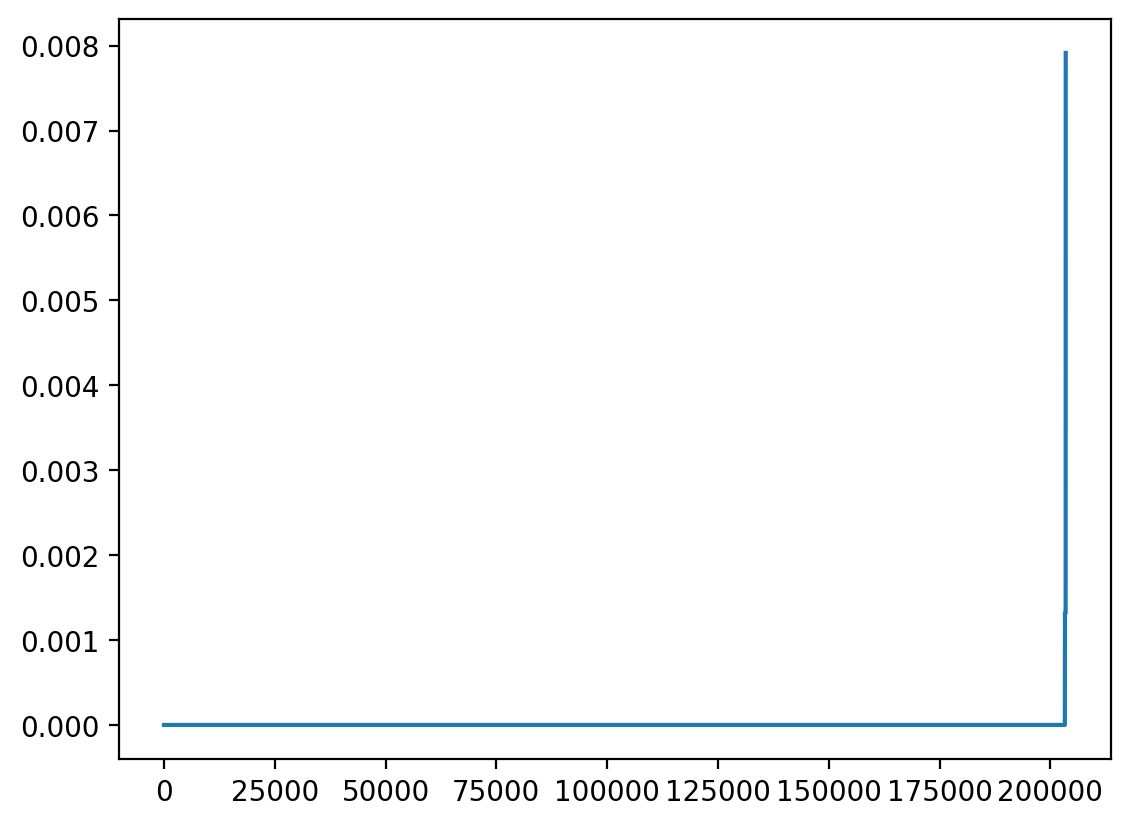

In [30]:
neighbors = NearestNeighbors(n_neighbors=100)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
#dist4 = distances[:3]
#dist10 = distances[:9]
distances = distances[:,1]
plt.plot(distances); 
# plt.plot(dist4)

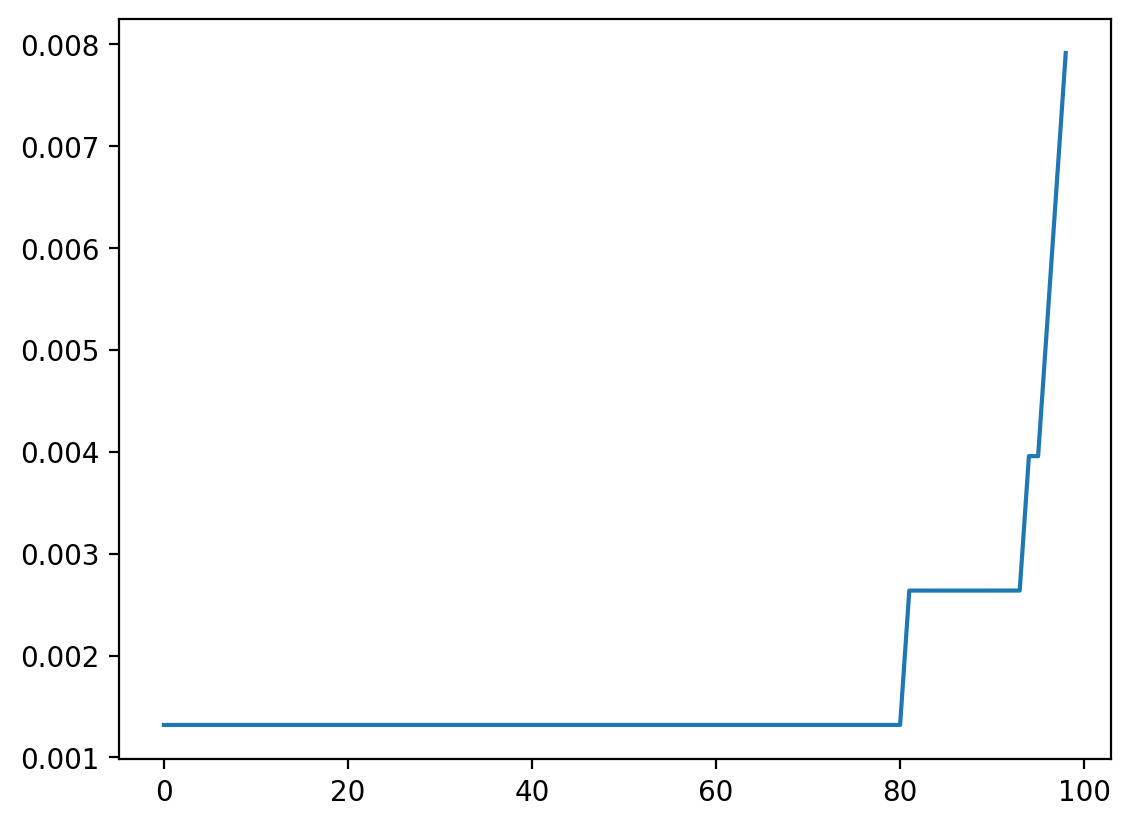

In [31]:
plt.plot(distances[-100:-1])
plt.show(); 

In [32]:
# this looks to be about .0029...

```ASSUME:  min_samples: 10```

In [33]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances[:-10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
indices[:1]

array([[ 76401, 184424, 126715, 171997, 129362, 184514,  76552,     40,
          9582, 171996]], dtype=int64)

In [35]:
type(neighbors)

sklearn.neighbors._unsupervised.NearestNeighbors

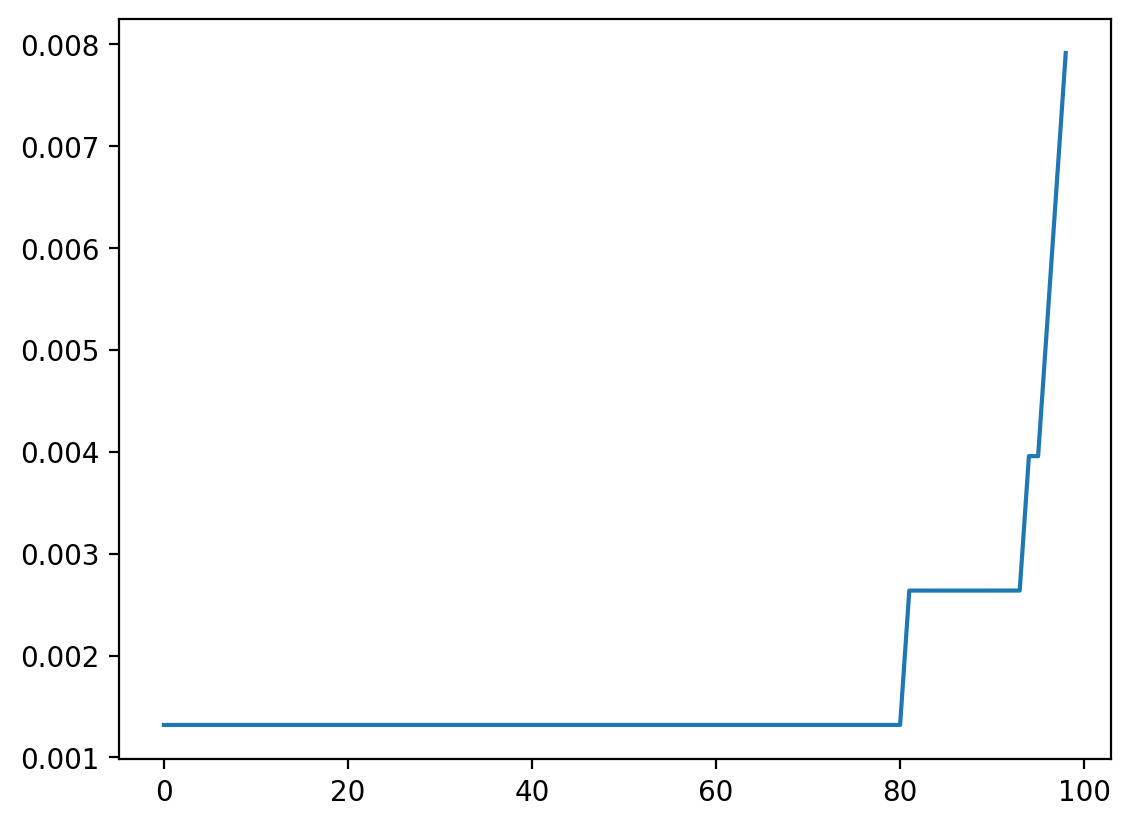

In [36]:
distances = np.sort(distances, axis=0)
#dist4 = distances[:3]
#dist10 = distances[:9]
distances = distances[:,1]
# plt.plot(distances); 
# plt.plot(dist4)
plt.plot(distances[-100:-1])
plt.show(); 

In [37]:
# this looks to be about .0029...

We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. 

The point itself is included in n_neighbors. 

The k-neighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

---

##  IMPORTANT: PLOTTING FOR CLARITY

In [38]:
neighbors = NearestNeighbors(n_neighbors=500)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [39]:
type(neighbors)

sklearn.neighbors._unsupervised.NearestNeighbors

In [40]:
# neighbors attributes:
#  'algorithm',
#  'effective_metric_',
#  'effective_metric_params_',
#  'fit',
#  'get_params',
#  'kneighbors',
#  'kneighbors_graph',
#  'leaf_size',
#  'metric',
#  'metric_params',
#  'n_features_in_',
#  'n_jobs',
#  'n_neighbors',
#  'n_samples_fit_',
#  'p',
#  'radius',
#  'radius_neighbors',
#  'radius_neighbors_graph',
#  'set_params'

In [41]:
neighbors.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 500,
 'p': 2,
 'radius': 1.0}

In [42]:
neighbors.algorithm

'auto'

In [43]:
neighbors.effective_metric_

'euclidean'

In [44]:
neighbors.n_samples_fit_

203481

In [45]:
# neighbors?

# n_neighbors : int, default=5
#     Number of neighbors to use by default for :meth:`kneighbors` queries.

# radius : float, default=1.0
#     Range of parameter space to use by default for :meth:`radius_neighbors`
#     queries.

# algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'
#     Algorithm used to compute the nearest neighbors:

#     - 'ball_tree' will use :class:`BallTree`
#     - 'kd_tree' will use :class:`KDTree`
#     - 'brute' will use a brute-force search.
#     - 'auto' will attempt to decide the most appropriate algorithm
#       based on the values passed to :meth:`fit` method.

#     Note: fitting on sparse input will override the setting of
#     this parameter, using brute force.

# leaf_size : int, default=30
#     Leaf size passed to BallTree or KDTree.  This can affect the
#     speed of the construction and query, as well as the memory
#     required to store the tree.  The optimal value depends on the
#     nature of the problem.

# metric : str or callable, default='minkowski'
#     the distance metric to use for the tree.  The default metric is
#     minkowski, and with p=2 is equivalent to the standard Euclidean
#     metric. See the documentation of :class:`DistanceMetric` for a
#     list of available metrics.
#     If metric is "precomputed", X is assumed to be a distance matrix and
#     must be square during fit. X may be a :term:`sparse graph`,
#     in which case only "nonzero" elements may be considered neighbors.

# p : int, default=2
#     Parameter for the Minkowski metric from
#     sklearn.metrics.pairwise.pairwise_distances. When p = 1, this is
#     equivalent to using manhattan_distance (l1), and euclidean_distance
#     (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.

# metric_params : dict, default=None
#     Additional keyword arguments for the metric function.

# n_jobs : int, default=None
#     The number of parallel jobs to run for neighbors search.
#     ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
#     ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
#     for more details.

# Attributes
# ----------
# effective_metric_ : str
#     Metric used to compute distances to neighbors.

# effective_metric_params_ : dict
#     Parameters for the metric used to compute distances to neighbors.

# n_samples_fit_ : int
#     Number of samples in the fitted data.

In [50]:
# PLOTTING:
# COMMENTING OUT SO NOTEBOOK SIZE STAYS NORMAL, SEE THE SCREENSHOT BELOW:

# import plotly.express as px
# fig = px.scatter(distances, title='Distance Curve')
# fig.update_xaxes(title_text='Distances', range=[203270, 203500], constrain="domain")
# fig.update_yaxes(title_text='Distance threshold (eps)')
# fig.show(); 

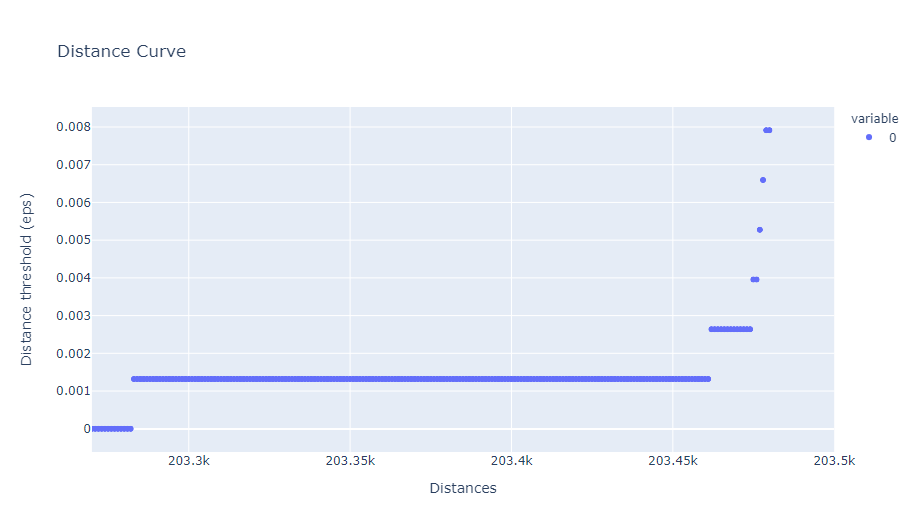

---

In [51]:
# trying a different min_samples size....
neighbors = NearestNeighbors(n_neighbors=25)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [52]:
neighbors.n_samples_fit_

203481

In [54]:
# PLOTTING:
# COMMENTING OUT for size and putting screenshot below

# import plotly.express as px
# fig = px.scatter(distances, title='Distance Curve: Looking for y-axis value (our estimate of eps hyperparameter) of the max curvature point...')
# fig = fig.update_xaxes(title_text='Distances', range=[203270, 203500], constrain="domain")
# fig = fig.update_yaxes(title_text='Distance threshold (eps)')
# fig.show()

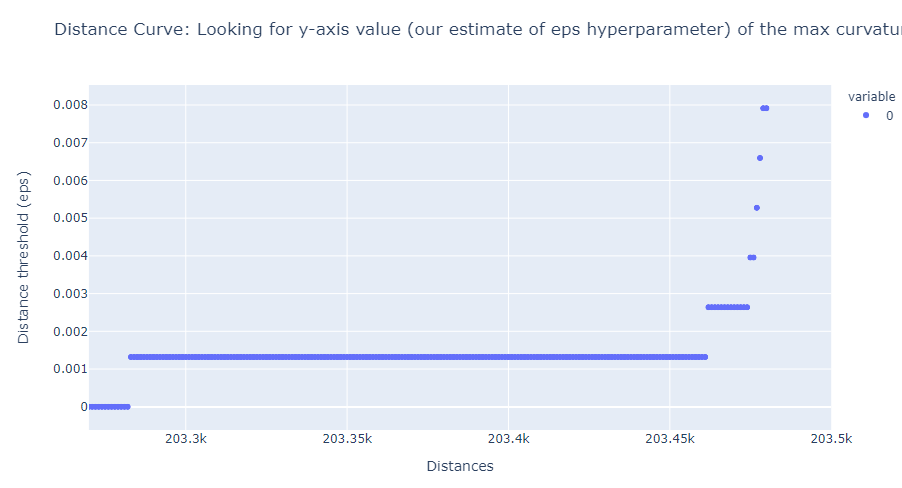

#### Observation:  It doesn't appear to matter how many min_samples you use ! 

---

##  Analysis: Choosing the right eps value based on these above plots ! 

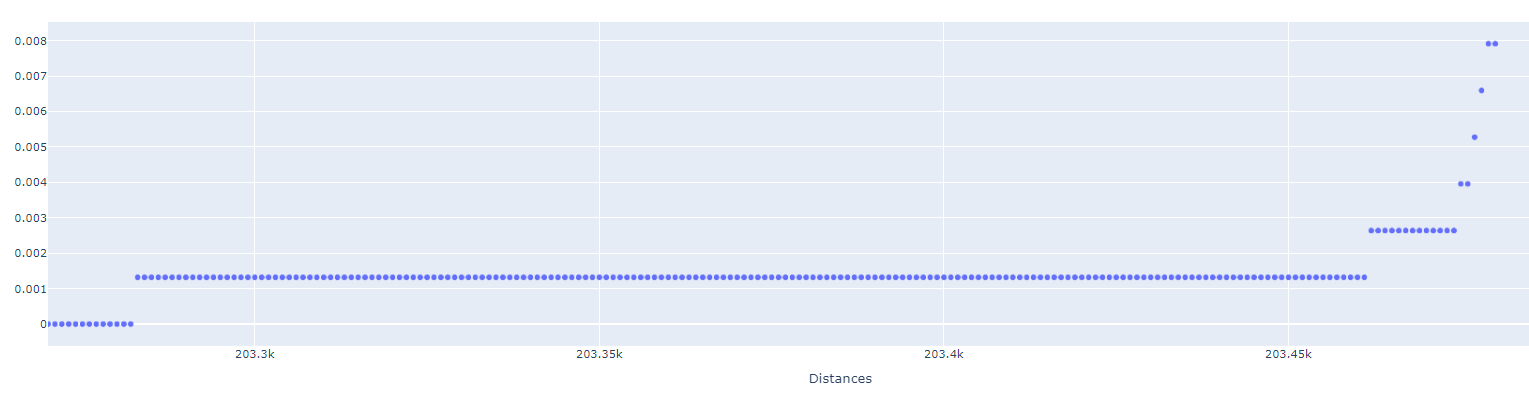

###  .003 appears to be a pretty good optimal eps hyperparameter to utilize according to this investigation...

<br>

##  Redoing the analysis of clusters with our determined optimal eps value...

In [55]:
# this is a different way of doing things

#  I will run a report, and save all results directly to a txt file and then upload...

# ---------------

# import sys
 
# eps_range = [.003]  # < - - - - - - - 

# min_samples_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 
#                      12, 13, 14, 15, 16, 17, 18, 
#                      19, 20, 21, 22, 23, 24, 25, 30, 35, 40, 
#                      45, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]

# sys.stdout = open('D:\dbscan_gridsearch_final_export_003_assumption.txt','wt')

# print('')
# print('eps:', eps_range)
# print('')
# print('min_samples range:')
# print(min_samples_range)
# print('')

# for i in eps_range:
#     for j in min_samples_range:
#         print('--- new min_pts ---')
#         db = DBSCAN(eps=i, min_samples=j, metric='euclidean', n_jobs=-1).fit(X)
#         label=db.labels_
#         sample_cores=np.zeros_like(label,dtype=bool)
#         sample_cores[db.core_sample_indices_]=True
#         n_clusters=len(set(label))- (1 if -1 in label else 0)
#         print('eps:', i, "  min_samples:", j)
#         print('Cluster Count:',n_clusters)
#         tsys["cluster"] = db.labels_
#         print(tsys["cluster"].value_counts(), '\n')
#         print("")
        
# this report was very very helpful...
        

> Output report: https://raw.githubusercontent.com/tombresee/SensorAnalysis/main/ENTER/results/FINAL_dbscan_gridsearch_export_correct.txt I think this helped alot in triangulating things...

##  Redoing the analysis of clusters with our determined optimal eps value...

#### This we will find will return us close results to our original 201 notebook.

In [56]:
len(X)

203481

In [57]:

myeps = .003
myminsamples = 25

db = DBSCAN(eps=myeps, min_samples=myminsamples, metric='euclidean', n_jobs=-1).fit(X)
print(db)
label=db.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
# Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print(myeps,myminsamples)
print('\nNo of clusters:',n_clusters, '\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()
# tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()


In [58]:
myeps

0.003

In [59]:
myminsamples

25

In [60]:
%cd D:\GITHUB_Repos\SensorAnalysis\ENTER\results

In [61]:
# so my results go into the right bin 

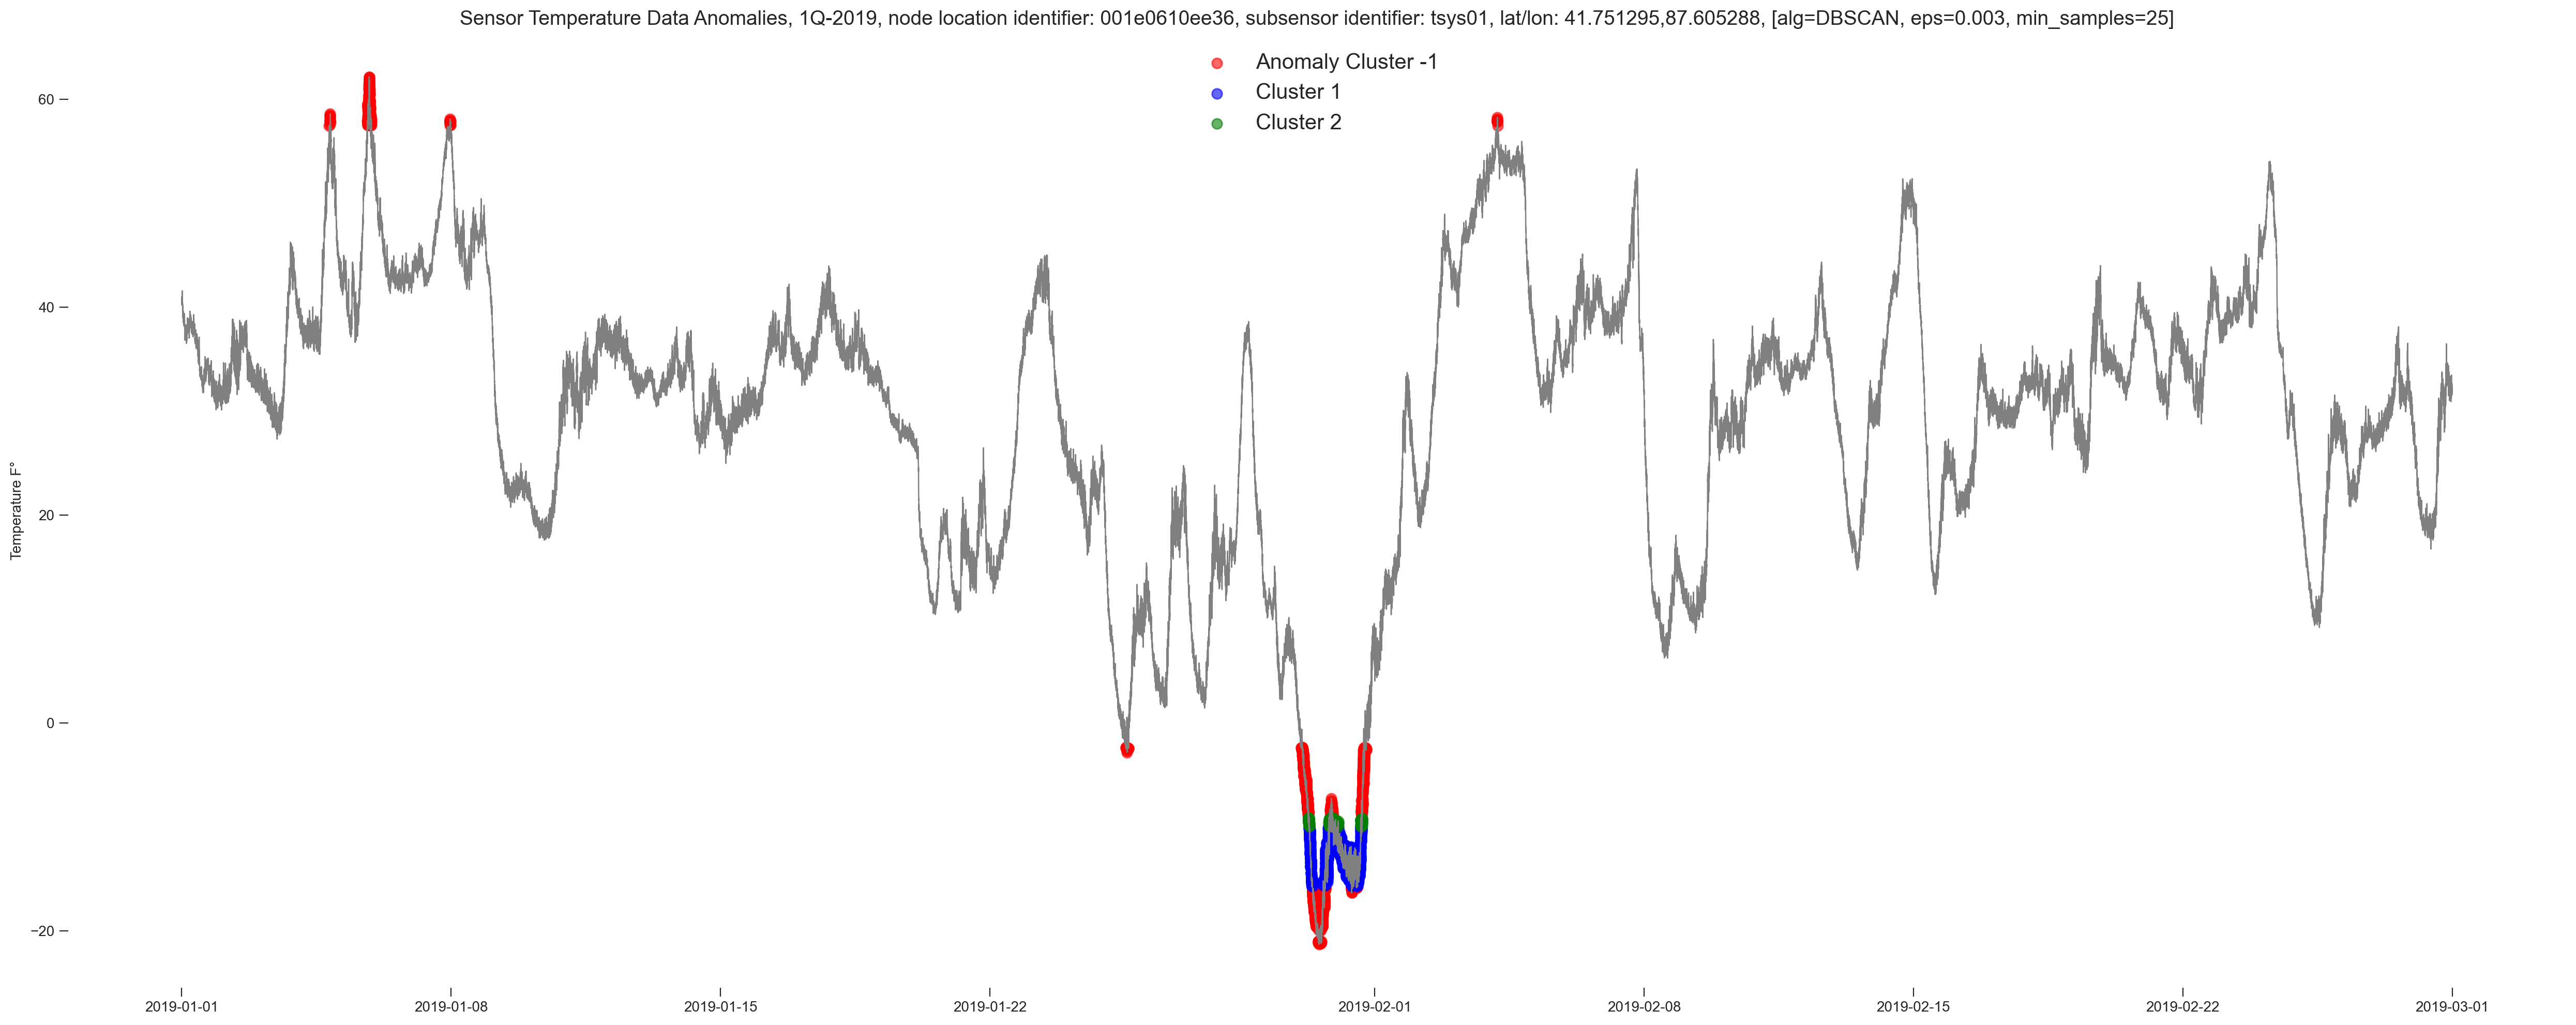

In [62]:

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 7].index
d= tsys[(tsys['cluster'] == 7)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Cluster 1', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 6].index
f= tsys[(tsys['cluster'] == 6)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Sensor Temperature Data Anomalies, 1Q-2019, node location identifier: 001e0610ee36, subsensor identifier: tsys01, lat/lon: 41.751295,87.605288, [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples), 
         fontsize=14)
plt.legend(loc='upper center', fontsize=15)
plt.tight_layout()
plt.box(False)
plt.show(); 

# plt.savefig('new_dbr_1.png', dpi=800); 


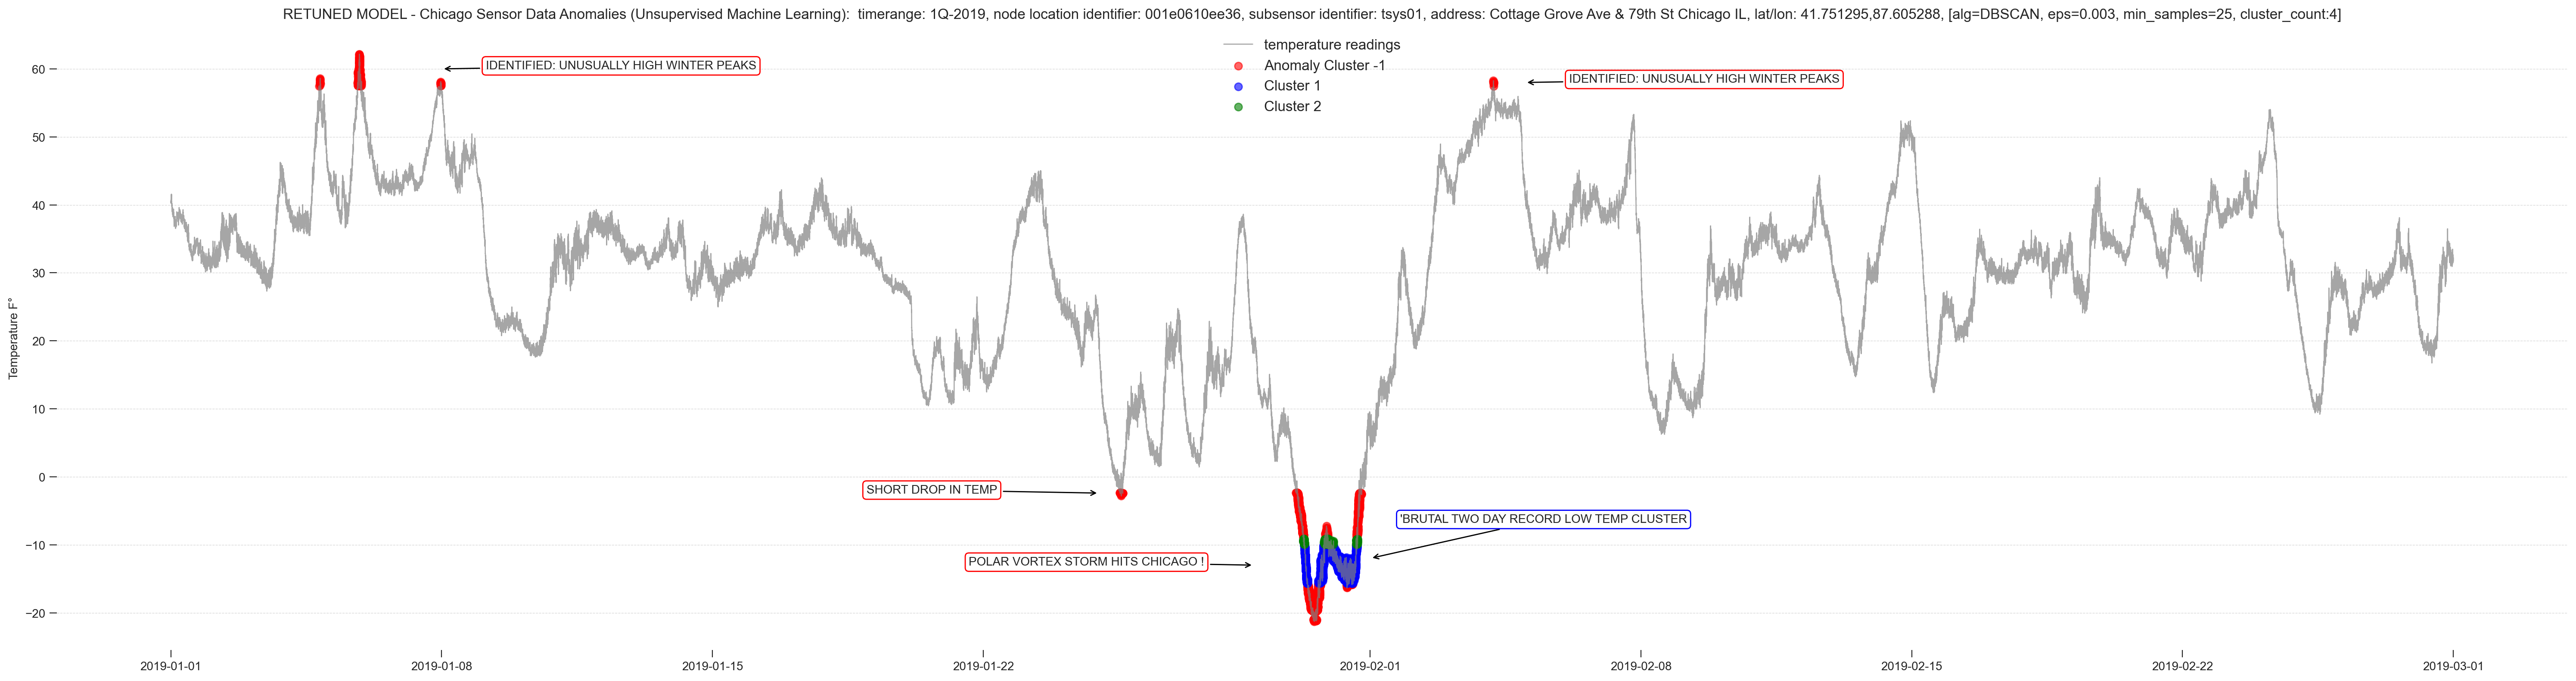

In [63]:

# plt.style.use('seaborn-ticks')
# plt.style.use('default')
plt.style.use('seaborn-ticks')

fig, ax = plt.subplots(figsize=(30,8))

# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# plt.style.use('white_background')
plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temperature readings")

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=40, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 7].index
d= tsys[(tsys['cluster'] == 7)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Cluster 1', s=40, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 6].index
f= tsys[(tsys['cluster'] == 6)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Cluster 2', s=40, alpha=0.6)


ax.annotate("IDENTIFIED: UNUSUALLY HIGH WINTER PEAKS", xy=(pd.Timestamp('2019-01-08'), 60),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(150,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("IDENTIFIED: UNUSUALLY HIGH WINTER PEAKS", xy=(pd.Timestamp('2019-02-05'), 58),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(150,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("POLAR VORTEX STORM HITS CHICAGO !", xy=(pd.Timestamp('2019-01-29'), -13),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(-140, 0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("SHORT DROP IN TEMP", xy=(pd.Timestamp('2019-01-25'), -2.4),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(-140, 0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))


ax.annotate("'BRUTAL TWO DAY RECORD LOW TEMP CLUSTER", xy=(pd.Timestamp('2019-02-01'), -12),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="blue"),
            xytext=(145, 30), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

plt.title('RETUNED MODEL - Chicago Sensor Data Anomalies (Unsupervised Machine Learning):  timerange: 1Q-2019, node location identifier: 001e0610ee36, subsensor identifier: tsys01, address: Cottage Grove Ave & 79th St Chicago IL, lat/lon: 41.751295,87.605288, [alg=DBSCAN, eps={0}, min_samples={1}, cluster_count:4]'.format(myeps, myminsamples), 
         fontsize=12)
plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=20)
plt.legend(loc='upper center', fontsize=12)
plt.ylabel('Temperature F°')
plt.box(False)
plt.tight_layout()
plt.show(); 
# plt.savefig('pow_tuned_2.png', dpi=800) # single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)
# plt.savefig('delta2.png', facecolor = 'white', dpi=600)
# plt.savefig('temp2.png', facecolor="black", edgecolor="none")


In [64]:
#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

# Previously tuned parameters, but for now really just looking around
myeps = .01
myminsamples = 25
#************************************************************************************
db = DBSCAN(eps=myeps, min_samples=myminsamples, metric='euclidean', n_jobs=-1).fit(X)
#************************************************************************************

# db.get_params(deep=True)
# {'algorithm': 'auto',
#  'eps': 0.01,
#  'leaf_size': 30,
#  'metric': 'euclidean',
#  'metric_params': None,
#  'min_samples': 25,
#  'n_jobs': -1,
#  'p': None}

label=db.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
# Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print(myeps,myminsamples)
print('\nNo of clusters:',n_clusters, '\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()
# tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()


```-- ITERATION 1 --
       Plotting the clusters that DBSCAN identified, with our base eps and min_samples hyperparameters:```

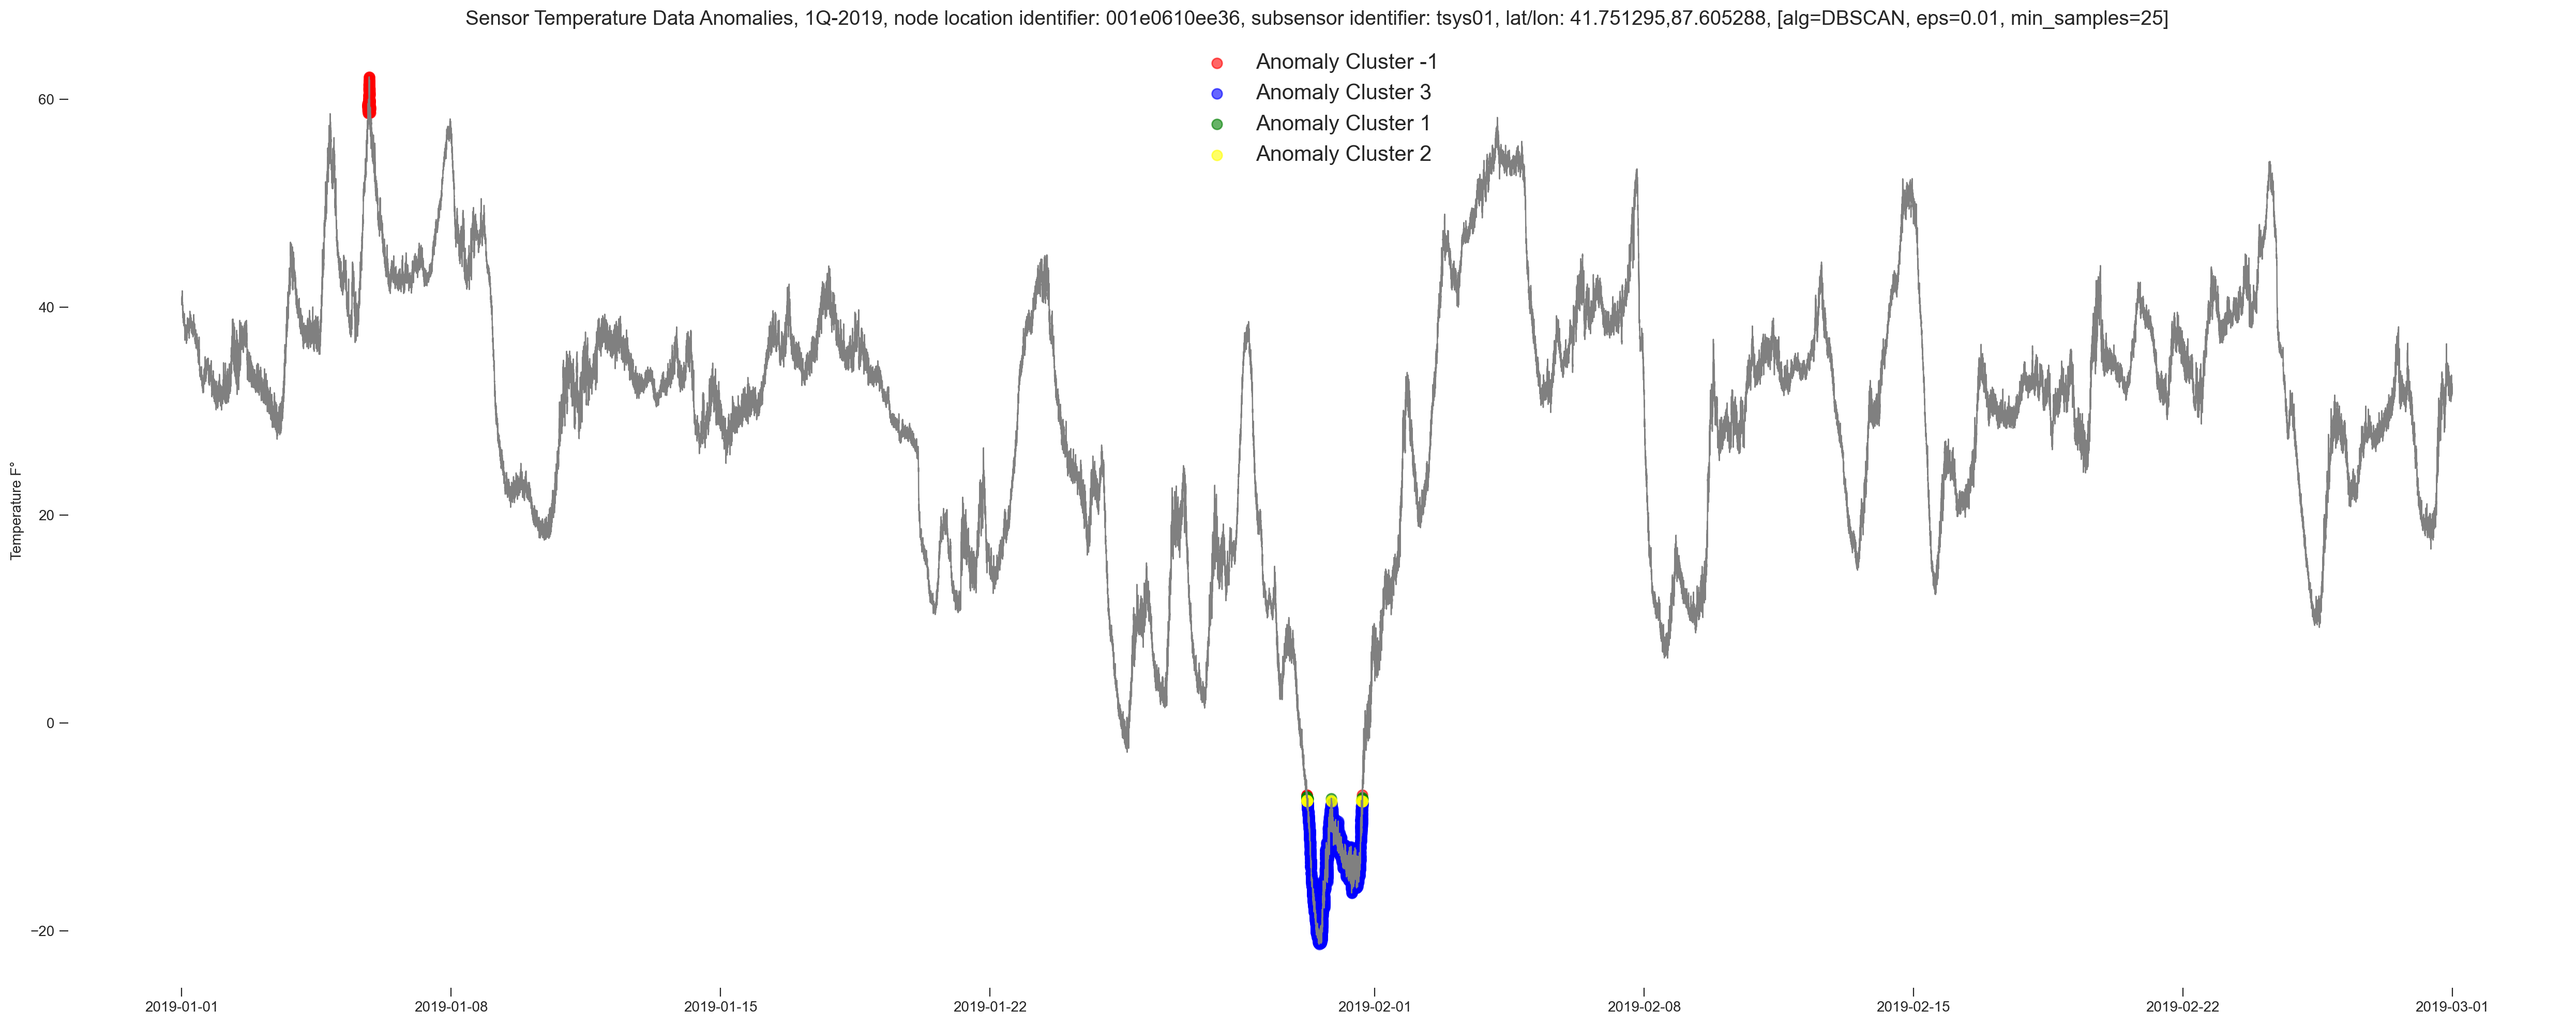

In [65]:
# AAA.  DO NOT LOSE THIS CODE, WORKING ! 

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('Sensor Temperature Data Anomalies, 1Q-2019, node location identifier: 001e0610ee36, subsensor identifier: tsys01, lat/lon: 41.751295,87.605288, [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples), 
         fontsize=14)
# plt.legend()
plt.legend(loc='upper center', fontsize=15)
plt.tight_layout()
plt.box(False)
plt.show();

# these results have been saved, comment out now be careful
# plt.savefig('dbr_1.png', dpi=800); 

```-- ITERATION 1 --
       Translating / Understanding what we are seeing with anomaly detection:```

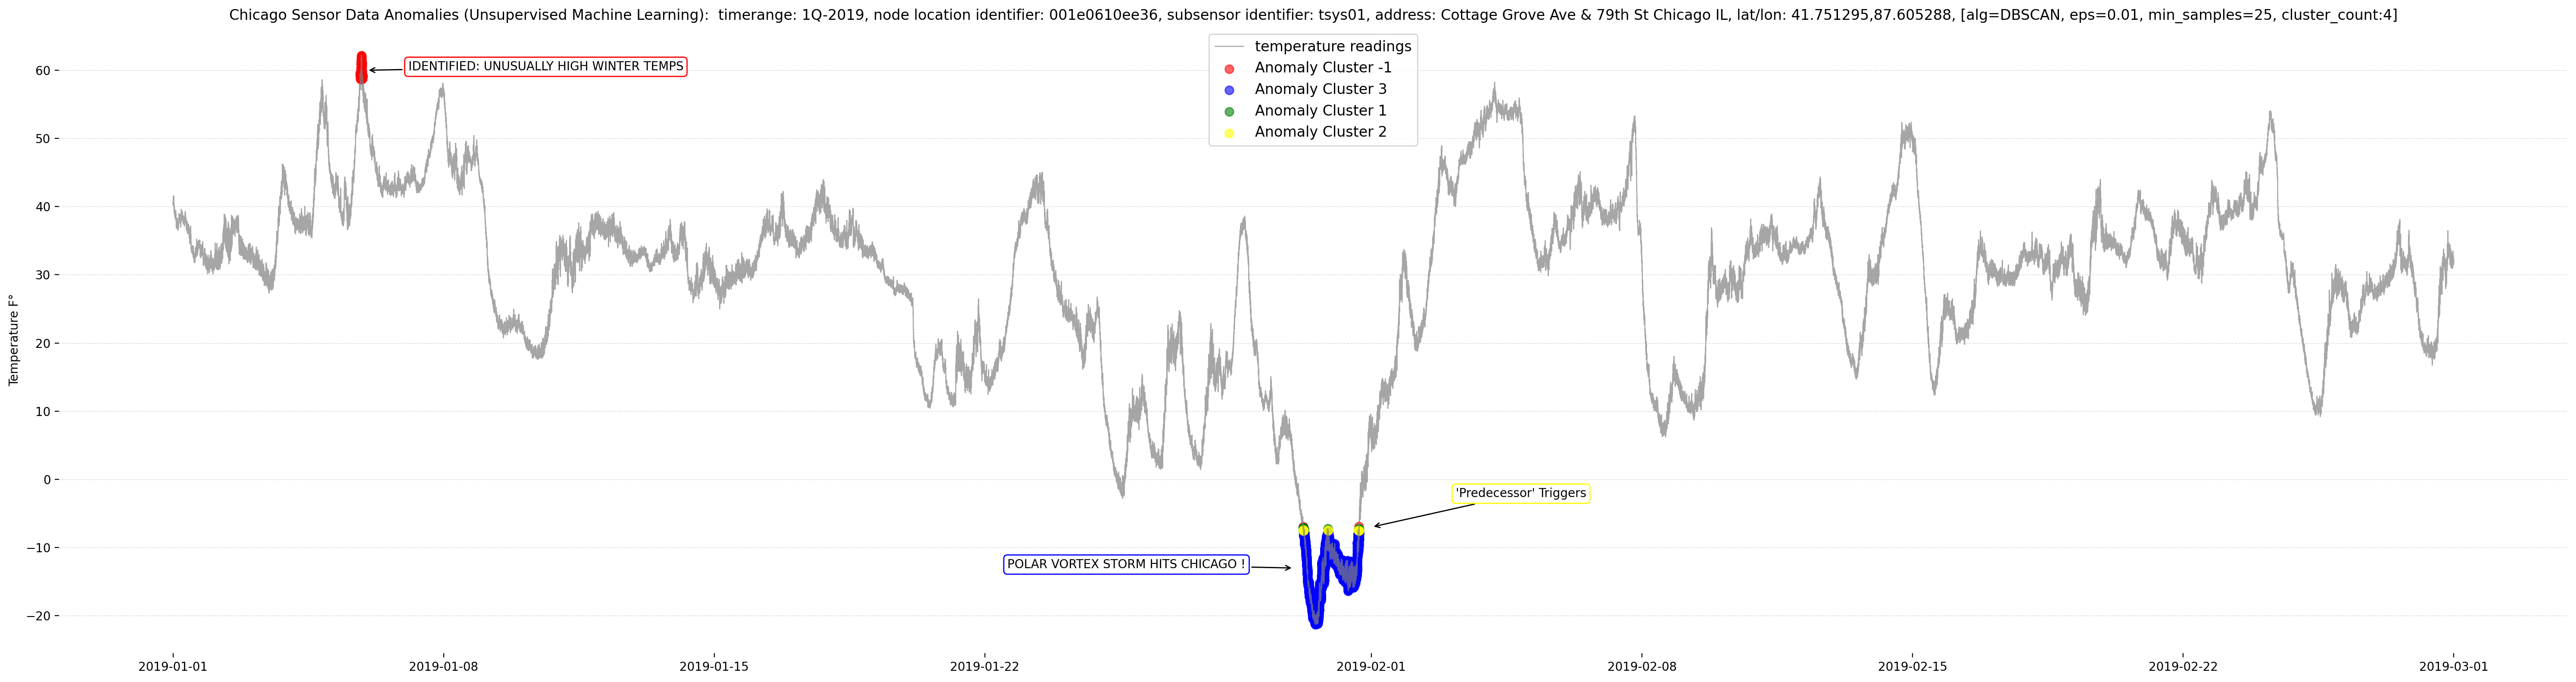

In [66]:
# BBB. DO NOT LOSE THIS CODE, WORKING

# plt.style.use('seaborn-ticks')
plt.style.use('default')

# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
fig, ax = plt.subplots(figsize=(30,8))
# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# plt.style.use('white_background')
plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temperature readings")

# --- original code 
# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=20, alpha=0.9)

# c = tsys.loc[tsys['cluster'] == 1].index
# d= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=20, alpha=0.9)

# e = tsys.loc[tsys['cluster'] == 2].index
# f= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=20, alpha=0.9)

# g = tsys.loc[tsys['cluster'] == 3].index
# h= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 3', s=20, alpha=0.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

# c = tsys.loc[tsys['cluster'] == 3].index
# d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# ax.annotate('local maximum', xy=('2019-01-01', 10), xytext=('2019-01-29', 5),
#             color="white", arrowprops=dict(facecolor='green', shrink=0.05))

# ax.annotate("Independence Day", xy=('2019-01-29', -20),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(10, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

ax.annotate("IDENTIFIED: UNUSUALLY HIGH WINTER TEMPS", xy=(pd.Timestamp('2019-01-06'), 60),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(150,0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("POLAR VORTEX STORM HITS CHICAGO !", xy=(pd.Timestamp('2019-01-30'), -13),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="blue"),
            xytext=(-140, 0), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("'Predecessor' Triggers", xy=(pd.Timestamp('2019-02-01'), -7),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="yellow"),
            xytext=(125, 25), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
plt.title('Chicago Sensor Data Anomalies (Unsupervised Machine Learning):  timerange: 1Q-2019, node location identifier: 001e0610ee36, subsensor identifier: tsys01, address: Cottage Grove Ave & 79th St Chicago IL, lat/lon: 41.751295,87.605288, [alg=DBSCAN, eps={0}, min_samples={1}, cluster_count:4]'.format(myeps, myminsamples), 
         fontsize=12)
plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=20)
plt.legend(loc='upper center', fontsize=12)
plt.ylabel('Temperature F°')
plt.box(False)
plt.tight_layout()
plt.show(); 

# plt.savefig('pow.png', dpi=800) # single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)
# plt.savefig('delta2.png', facecolor = 'white', dpi=600)
# plt.savefig('temp2.png', facecolor="black", edgecolor="none")

```-- ITERATION 1 --
       Visualizing some closeup ranges (red anomaly and blue anomaly regions):```

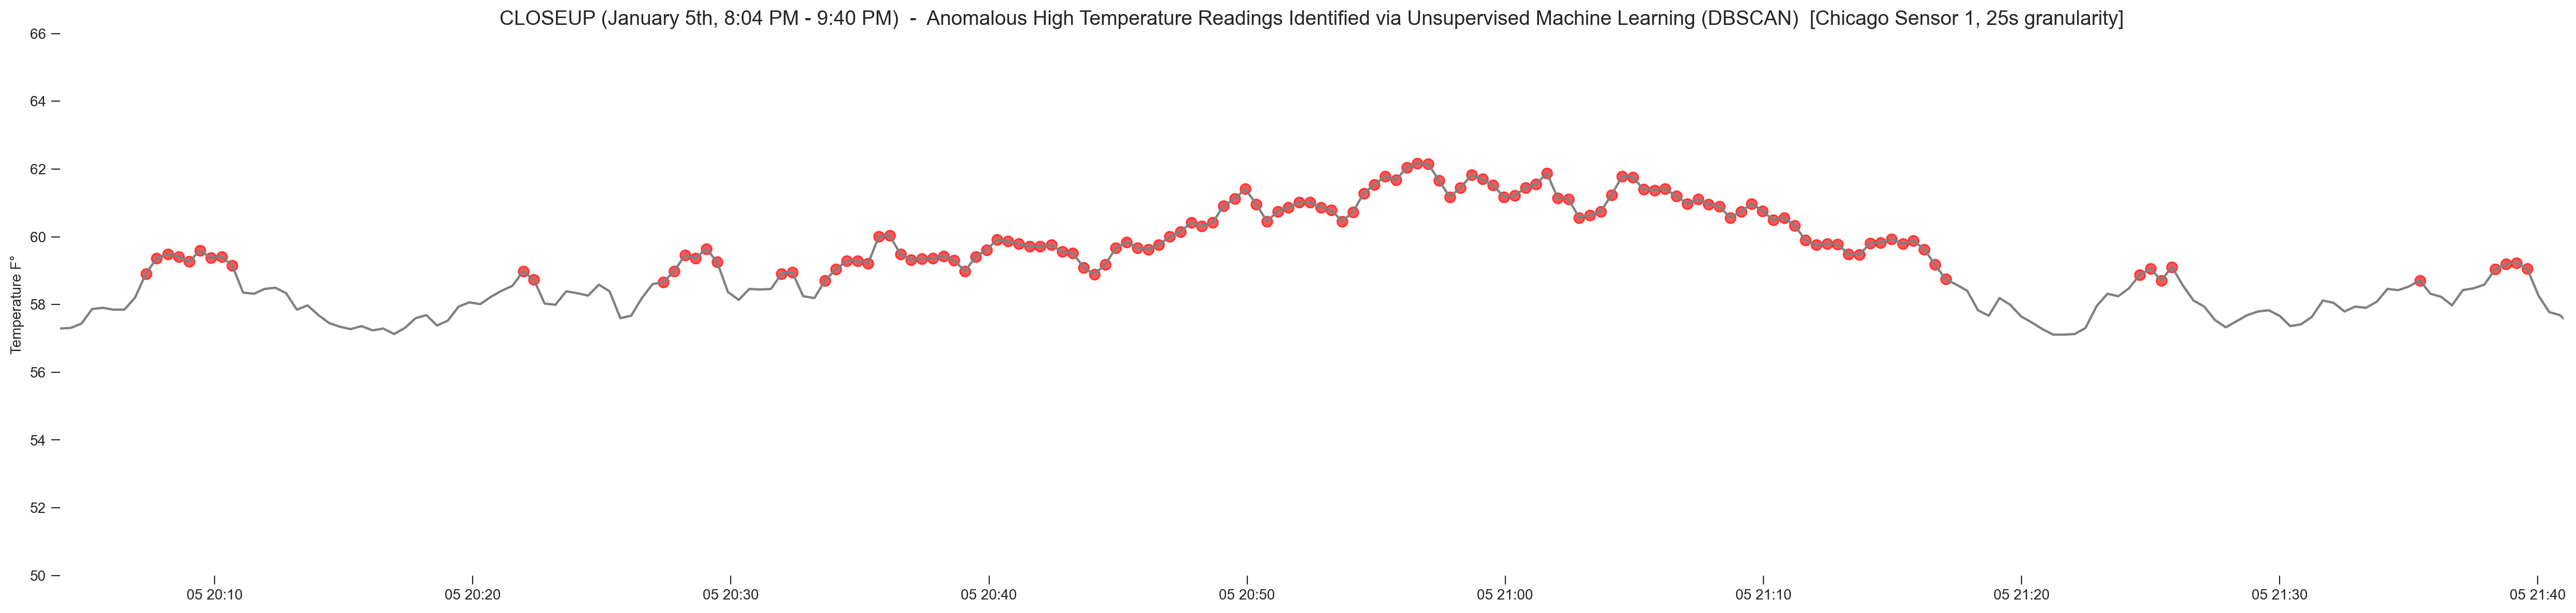

In [67]:
# ccc.  WINDOWS AND RANGES

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 6))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1.5, linewidth=1.6)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=52, alpha=0.66)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

# ax.annotate("POLAR VORTEX STORM HITS CHICAGO !", xy=(pd.Timestamp('2019-01-05 21:00:00'), 60),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="blue"),
#             xytext=(-140, 0), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('CLOSEUP (January 5th, 8:04 PM - 9:40 PM)  -  Anomalous High Temperature Readings Identified via Unsupervised Machine Learning (DBSCAN)  [Chicago Sensor 1, 25s granularity]'.format(myeps, myminsamples), 
         fontsize=14)
# plt.legend()
# plt.legend(loc='center', fontsize=15)

plt.xlim(pd.Timestamp('2019-01-05 20:04:00'), pd.Timestamp('2019-01-05 21:41:00'))

plt.ylim((50, 66))
# @#pd.Timestamp('2019-01-05 19:59:20'), pd.Timestamp('2019-01-05 21:26:33'))

plt.tight_layout()
plt.box(False)
plt.show();

# these results have been saved, comment out now be careful
# plt.savefig('dbr_1_r1.png', dpi=800); 

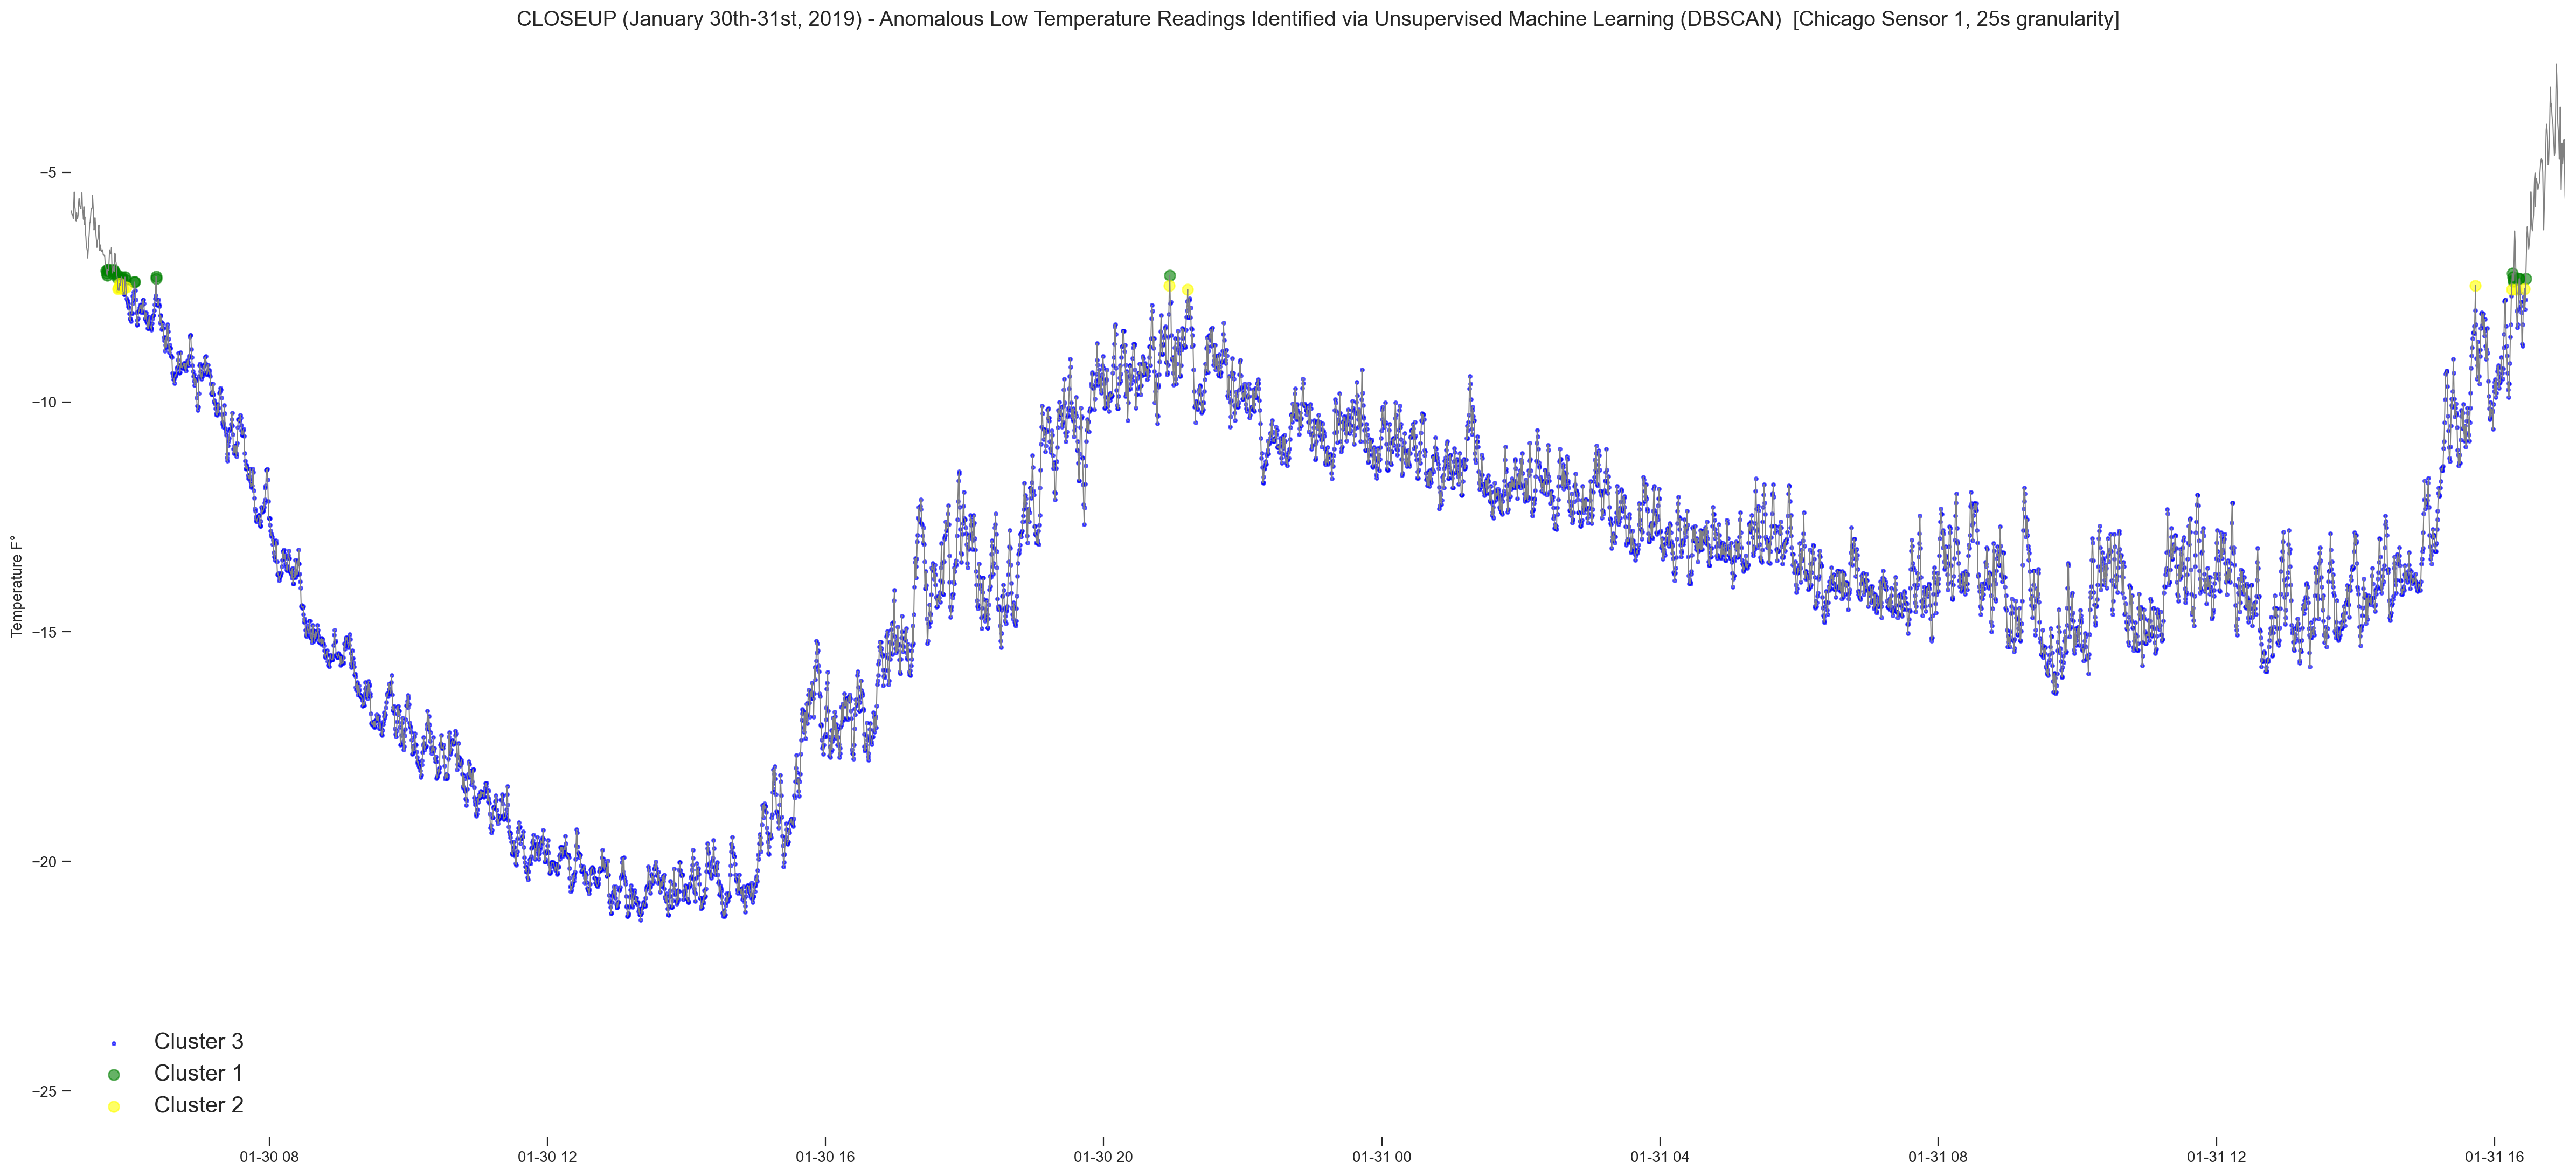

In [68]:
# secondary window

plt.style.use('seaborn-ticks')
plt.figure(figsize=(24, 11))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1.5, linewidth=.7)

# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=52, alpha=0.66)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Cluster 3', s=5, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='green', label = 'Cluster 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Cluster 2', s=50, alpha=0.6)
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('CLOSEUP (January 30th-31st, 2019) - Anomalous Low Temperature Readings Identified via Unsupervised Machine Learning (DBSCAN)  [Chicago Sensor 1, 25s granularity]'.format(myeps, myminsamples), 
         fontsize=14)
# plt.legend()
plt.legend(loc='lower left', fontsize=15)

plt.xlim(pd.Timestamp('2019-01-30 05:09:00'), pd.Timestamp('2019-01-31 17:01:00'))

plt.ylim((-26,-2))
# @#pd.Timestamp('2019-01-05 19:59:20'), pd.Timestamp('2019-01-05 21:26:33'))

plt.tight_layout()
plt.box(False)
plt.show();

# these results have been saved, comment out now be careful
# plt.savefig('dbr_1_r2e.png', dpi=700); 

```As a reference, we use plotly to show all the temperature values over the entire range, 
so readers can home in on the window they wish to view/explore...```

In [ ]:
import plotly.express as px
# fig = px.scatter(tsys, x=tsys.index, 
#                  y=tsys.value_hrf, 
#                  title="1Q 2019 - Chicago Sensor 1 - Raw Data (Temperature in F)", 
#                         template = "plotly_dark").update_traces(marker=dict(size=1,
#                               line=dict(width=.5,
#                                         color='darkgrey')),
#                   selector=dict(mode='markers')).update_layout(yaxis_title="Temperature F°")
# fig.write_html("temp_1q_2019_chicago.html")
# fig.show()
# Uncomment everything out, and it will show the following (via url):

> https://ghcdn.rawgit.org/tombresee/SensorAnalysis/main/ENTER/results/temp_1q_2019_chicago.html

```-- ITERATION 1 --
       Outputting and exporting the actual anomalous values (ranges), and plotting shaded regions...```

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

print('\nANOMALOUS REGION ("RED", Cluster -1):')
print('(can export to .txt if desired)')


# for date in a.values:
#     print(a)
for c in range(140):
    print(a[c])
    # print(a[0])
    # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
print('Red Window Start:', min_a)
print('Red Window End:  ', max_a)
print("")
plt.axvspan(min_a, max_a, alpha=.3, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
print('Dominant Blue Window Start:', min_c)
print('Dominant Blue Window End:  ', max_c)

line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.3, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
# plt.legend(loc='upper center', borderaxespad=0.)
plt.tight_layout()
plt.box(False)

plt.xlim(pd.Timestamp('2019-01-05 20:07:20'), pd.Timestamp('2019-01-31 16:26:33'))
# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))

plt.show();

# plt.savefig('dbrun_1.png', dpi=800);

In [ ]:
# # BBB. DO NOT LOSE THIS CODE, WORKING

# plt.style.use('seaborn-ticks')

# fig, ax = plt.subplots(figsize=(30,8))
# # plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# # plt.style.use('white_background')
# plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temp sensor")

# # --- original code 
# # a = tsys.loc[tsys['cluster'] == -1].index
# # b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# # plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=20, alpha=0.9)

# # c = tsys.loc[tsys['cluster'] == 1].index
# # d= tsys[(tsys['cluster'] == 1)]['value_hrf']
# # plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=20, alpha=0.9)

# # e = tsys.loc[tsys['cluster'] == 2].index
# # f= tsys[(tsys['cluster'] == 2)]['value_hrf']
# # plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=20, alpha=0.9)

# # g = tsys.loc[tsys['cluster'] == 3].index
# # h= tsys[(tsys['cluster'] == 3)]['value_hrf']
# # plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 3', s=20, alpha=0.9)


# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']
# plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

# c = tsys.loc[tsys['cluster'] == 3].index
# d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# # ax.annotate('local maximum', xy=('2019-01-01', 10), xytext=('2019-01-29', 5),
# #             color="white", arrowprops=dict(facecolor='green', shrink=0.05))

# # ax.annotate("Independence Day", xy=('2019-01-29', -20),  xycoords='data',
# #             bbox=dict(boxstyle="round", fc="none", ec="gray"),
# #             xytext=(10, -40), textcoords='offset points', ha='center',
# #             arrowprops=dict(arrowstyle="->"))

# ax.annotate("Unusually High Winter Temps", xy=(pd.Timestamp('2019-01-06'), 60),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="red"),
#             xytext=(130,20), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

# ax.annotate("Polar Vortex Storm Hits Chicago !", xy=(pd.Timestamp('2019-01-30'), -12),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="yellow"),
#             xytext=(-140, 20), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

# # https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
# plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
# plt.locator_params(axis='y', nbins=10)
# plt.locator_params(axis='x', nbins=20)
# plt.legend(loc='upper center', borderaxespad=0.)
# plt.ylabel('Temperature F°')
# plt.box(False)
# plt.tight_layout()
# plt.show(); 

# # plt.savefig('single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

print('\nANOMALOUS REGION (Cluster: -1):')
# for date in a.values:
#     print(a)
# for c in range(140):
    # halt for now print(a[c])
    # print(a[0])
    # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
print('Red Window Start:', min_a)
print('Red Window End:  ', max_a)
print('Plotting below:')
print("")
plt.axvspan(min_a, max_a, alpha=.2, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)


print('\nANOMALOUS REGION (Cluster: 1):\n')

print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
print('Dominant Blue Window Start:', min_c)
print('Dominant Blue Window End:  ', max_c)
print('Plotting second below:\n')


line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.3, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
# plt.legend(loc='upper center', borderaxespad=1)
# plt.tight_layout()
plt.box(False)

plt.xlim(pd.Timestamp('2019-01-05 19:55:00'), pd.Timestamp('2019-01-05 22:00:00'))
# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))

plt.show();

# plt.savefig('dbrun_1.png', dpi=800);

In [ ]:
# adding shade !!!!!!!!!!!!

plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 10))

plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

# print('\nANOMALOUS REGION ("RED", Cluster -1):')
# for date in a.values:
#     print(a)
# for c in range(140):
#     print(a[c])
#     # print(a[0])
#     # print(a[1])

min_a = a.min()
max_a = a[-9]
print("")
# print('Red Window Start:', min_a)
# print('Red Window End:  ', max_a)
print("")
plt.axvspan(min_a, max_a, alpha=.3, color='red')

# line1 = min_a
# line2 = max_a
# ax.axvspan(line1, line2, alpha=.7, color='red')

# plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# print('ARCTIC POLAR VORTEX:')
min_c = c.min()
max_c = c.max()
# print('Dominant Blue Window Start:', min_c)
# print('Dominant Blue Window End:  ', max_c)

line1 = min_c
line2 = max_c
plt.axvspan(line1, line2, alpha=.2, color='blue')
# plt.axvline(x=0.22058956)


# e = tsys.loc[tsys['cluster'] == 1].index
# f= tsys[(tsys['cluster'] == 1)]['value_hrf']
# plt.scatter(e, f, color='green', label = 'Anomaly Cluter 1', s=50, alpha=0.6)

# g = tsys.loc[tsys['cluster'] == 2].index
# h= tsys[(tsys['cluster'] == 2)]['value_hrf']
# plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

plt.ylabel('Temperature F°')
plt.title('Temp Data Anomalies     1Q-2019     [alg=DBSCAN, eps={0}, min_samples={1}]'.format(myeps, myminsamples))
plt.tight_layout()
plt.box(False)
plt.xlim(pd.Timestamp('2019-01-29 23:07:20'), pd.Timestamp('2019-02-01 00:26:33'))
plt.ylim( (-30, 10))
# pd.Timestamp('2019-01-29 23:07:20'), pd.Timestamp('2019-02-01 00:26:33'))

# ax.set_xlim(pd.Timestamp('2015-02-15'), pd.Timestamp('2015-07-01'))
plt.show();

In [ ]:
# miniplot if you wanted: 
# plt.figure(figsize=(20, 20))
# plt.scatter(e, f, color='orange', label = 'Anomaly Cluster 2', s=50, alpha=0.6)
# plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=50, alpha=0.6)
# plt.show();  


---
---

### ITERATE 1:

In [ ]:
#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

myeps = .01
myminsamples = 25
#************************************************************************************
db = DBSCAN(eps=myeps, min_samples=myminsamples, metric='euclidean', n_jobs=-1).fit(X)
#************************************************************************************
# db.get_params(deep=True)
# {'algorithm': 'auto',
#  'eps': 0.01,
#  'leaf_size': 30,
#  'metric': 'euclidean',
#  'metric_params': None,
#  'min_samples': 25,
#  'n_jobs': -1,
#  'p': None}

label=db.labels_
#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)
sample_cores[db.core_sample_indices_]=True
# Calculating the number of clusters
n_clusters=len(set(label))- (1 if -1 in label else 0)
print(myeps,myminsamples)
print('\nNo of clusters:',n_clusters, '\n')
# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')
tsys["cluster"] = db.labels_
print(tsys["cluster"].value_counts(), '\n')
#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()
# tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(25, 8))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

c = tsys.loc[tsys['cluster'] == 3].index
d= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

e = tsys.loc[tsys['cluster'] == 1].index
f= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

g = tsys.loc[tsys['cluster'] == 2].index
h= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature F°')
# plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.title('Temp Data Anomalies, eps = {}'.format(myeps))

plt.legend()
plt.tight_layout()
plt.box(False)
plt.show();

In [ ]:

# use dark background !!!!!!!!!!!!!!!!!!!!!!

fig, ax = plt.subplots(figsize=(30,8))

# plt.style.use('white_background')
# plt.figure(figsize=(30, 8))

plt.plot(tsys.index, tsys.value_hrf, color = 'grey', alpha = .7, markersize=.8, linewidth=.9, label="temp sensor")

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=20, alpha=0.9)

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=20, alpha=0.9)

e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=20, alpha=0.9)

g = tsys.loc[tsys['cluster'] == 3].index
h= tsys[(tsys['cluster'] == 3)]['value_hrf']
plt.scatter(g, h, color='yellow', label = 'Anomaly Cluster 3', s=20, alpha=0.9)

# ax.annotate('local maximum', xy=('2019-01-01', 10), xytext=('2019-01-29', 5),
#             color="white", arrowprops=dict(facecolor='green', shrink=0.05))

# ax.annotate("Independence Day", xy=('2019-01-29', -20),  xycoords='data',
#             bbox=dict(boxstyle="round", fc="none", ec="gray"),
#             xytext=(10, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->"))

ax.annotate("Unusually High Winter Temps", xy=(pd.Timestamp('2019-01-06'), 60),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="red"),
            xytext=(130,20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

ax.annotate("Polar Vortex Storm Hits Chicago !", xy=(pd.Timestamp('2019-01-30'), -12),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="yellow"),
            xytext=(-140, 20), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"))

# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html

plt.title(r'Temperature Data Anomalies - Chicago Sensor (alg: DBSCAN, time window: 2 months, sensor node identifier: 001e0610ee36, subsensor: tsys01)')
plt.grid(axis='y', color='grey', linestyle='--', linewidth=.5, alpha=.3)
plt.locator_params(axis='y', nbins=10)
plt.locator_params(axis='x', nbins=20)
plt.legend(loc = "upper left")

plt.ylabel('Temperature F°')
plt.box(False)

plt.tight_layout()
# plt.show(); 

plt.savefig('single_subsensor_temp_data_two_month_dbscan_clusters.png', dpi=600)


Five records were set for Chicago for the month of January 2019:
* Record daily snowfall of 5.0 inches on the 28th.
* Record daily minimum temperature of -23 degrees on the 30th.
* Record daily lowest maximum temperature of -10 degrees on the
  30th.
* Record daily minimum temperature of -21 degrees on the 31st.
* Tied daily lowest maximum temperature of 1 degree on the 31st.

In [ ]:
# plt.figure(figsize=(20, 6))
# plt.scatter(g, h, color='grey', label = 'Anomaly Cluster 3', s=5, alpha=0.5)
# plt.show();  

In [ ]:

# # db = DBSCAN(eps=0.01, min_samples=25, metric='euclidean', n_jobs=-1).fit(X)

# plt.figure(figsize=(35, 50))

# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']

# c = tsys.loc[tsys['cluster'] == 1].index
# d= tsys[(tsys['cluster'] == 1)]['value_hrf']

# e = tsys.loc[tsys['cluster'] == 2].index
# f= tsys[(tsys['cluster'] == 2)]['value_hrf']

# g = tsys.loc[tsys['cluster'] == 3].index
# h= tsys[(tsys['cluster'] == 3)]['value_hrf']

# plt.scatter(e, f, color='orange', label = 'Anomaly Cluster 2', s=50, alpha=0.6)

# plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=50, alpha=0.6)

# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=50, alpha=0.6)

# plt.scatter(g, h, color='black', label = 'Anomaly Cluster 3', s=50, alpha=0.6)

# # plt.xlabel('Arrival Date')
# plt.ylabel('Temperature C°')
# plt.legend()
# plt.box(False)

# plt.show();  


In [ ]:
# The lowest temperature at Chicago was -23 degrees observed at Chicago O'Hare International Airport on January 30th.
# The lowest temperature at Rockford was -31 degrees observed at Chicago Rockford International Airport on January 31st. 
# The lowest temperature at NWS Chicago in Romeoville was -24 degrees.  This ties the record set on January 16, 2009.
# The lowest temperature at Chicago Midway Airport 3SW observed was -22 degrees on January 31, 2019. 

In [ ]:

# plt.figure(figsize=(25, 5))

# plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)

# a = tsys.loc[tsys['cluster'] == -1].index
# b= tsys[(tsys['cluster'] == -1)]['value_hrf']

# c = tsys.loc[tsys['cluster'] == 1].index
# d= tsys[(tsys['cluster'] == 1)]['value_hrf']

# # e = tsys.loc[tsys['cluster'] == 2].index
# # f= tsys[(tsys['cluster'] == 2)]['value_hrf']
# # plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=35, alpha=0.7)

# plt.scatter(a, b, color='red', label = 'Anomaly Cluster -1', s=35, alpha=0.7)
# plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)

# # plt.xlabel('Arrival Date')
# plt.ylabel('Temperature C°')
# plt.legend()
# plt.box(False)

# plt.show();  


```
RESULTS:
    
db = DBSCAN(eps=0.01, min_samples=30, metric='euclidean', n_jobs=-1).fit(X)
 0    139272
 3      4284
 4       664
 2       403
-1       126
 1       104
    

BELOW SHOWN IN PLOT:

db = DBSCAN(eps=0.01, min_samples=20, metric='euclidean', n_jobs=-1).fit(X)
 0    139842
 1      4988
-1        23
NOT BAD ! 


```    

In [ ]:
# EVERYTHING BELOW THIS LINE STILL WORKING ON:

# Appendix:  Do Not Delete

```python
from sklearn.cluster import DBSCAN
clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(ts_dataframe['Normalized Profit']).reshape(-1,1))

labels = clustering1.labels_

outlier_pos = np.where(labels == -1)[0]

x = []; y = [];
for pos in outlier_pos:
    x.append(np.array(ts_dataframe['Normalized Profit'])[pos])
    y.append(ts_dataframe['Normalized Profit'].index[pos])
    
plt.plot(ts_dataframe['Normalized Profit'].loc[ts_dataframe['Normalized Profit'].index], 'k-')
plt.plot(y,x,'r*', markersize=8)  
plt.legend(['Actual', 'Anomaly Detected'])
plt.xlabel('Time Period')
plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Normalized Profit')
```

In [ ]:
# # Sets the figure size temporarily but has to be set again the next plot
# plt.figure(figsize=(20,16))
# sns.lineplot(x=tdf.index, y="value_hrf", hue="sensor", data=tdf); 
# plt.show()

In [ ]:

# tdf = tdf[tdf['sensor'].isin(['bmp180', 'htu21d', 'pr103j2', 'tsys01'])]


In [ ]:

# Sets the figure size temporarily but has to be set again the next plot
# plt.figure(figsize=(20,16))
# sns.lineplot(x=tdf.index, y="value_hrf", hue="sensor", data=tdf); 
# plt.show()


* dont use:
 * tmp421
 * tmp112
 * hih6130
 

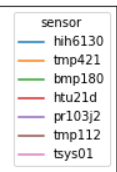

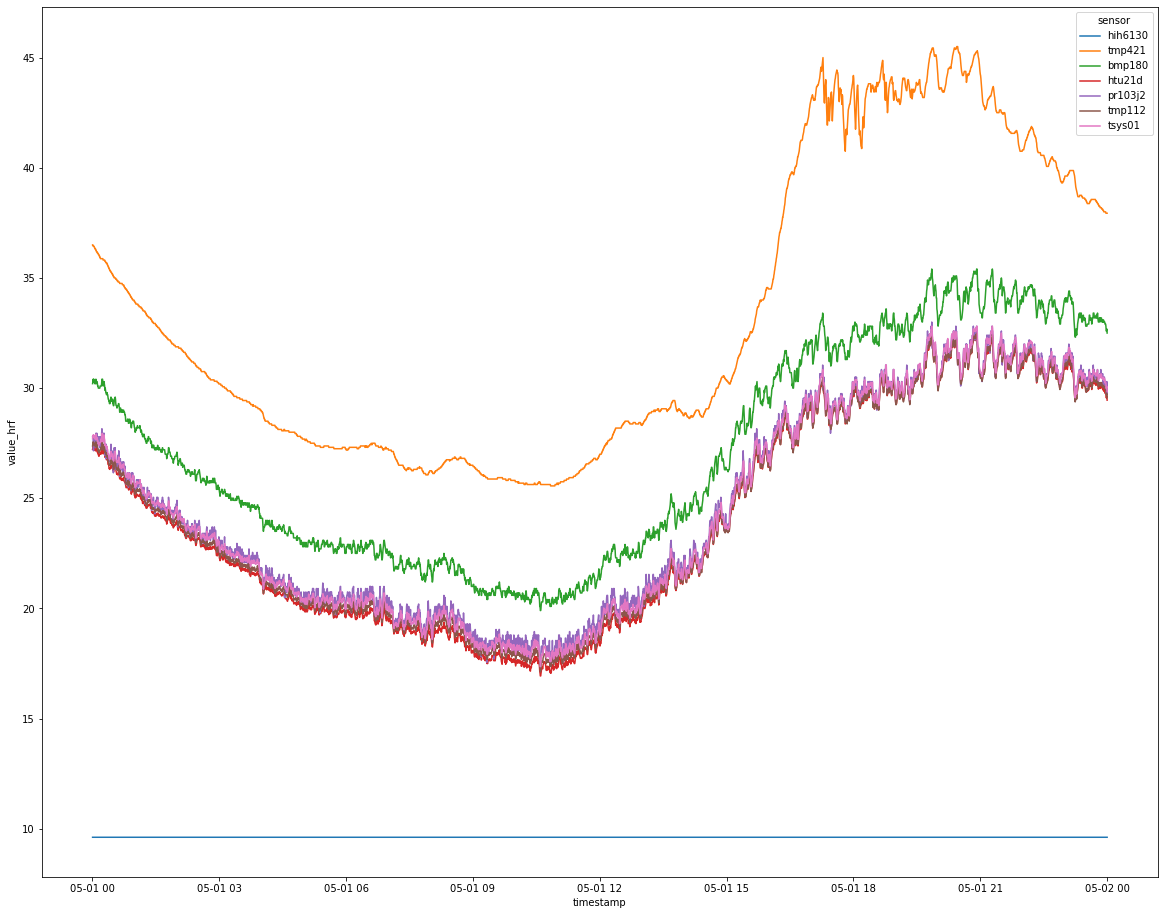

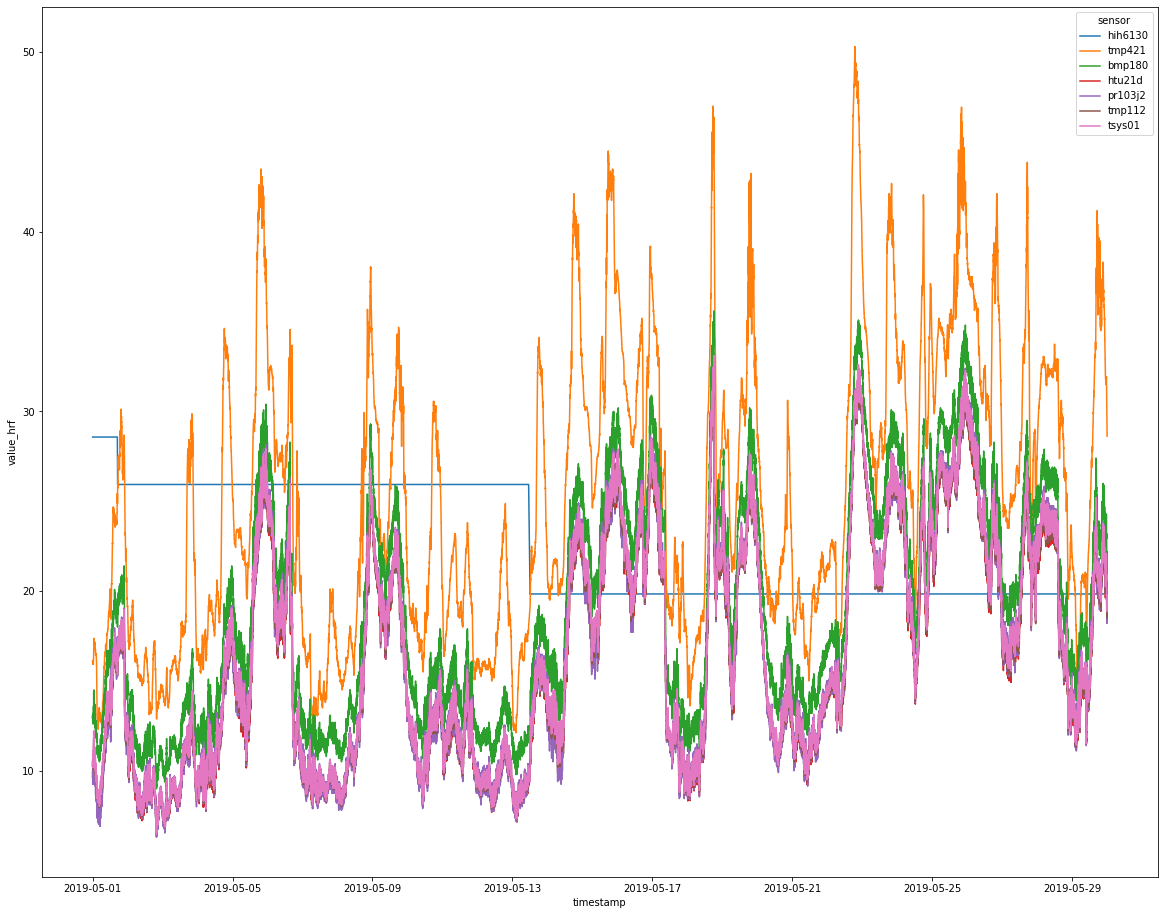

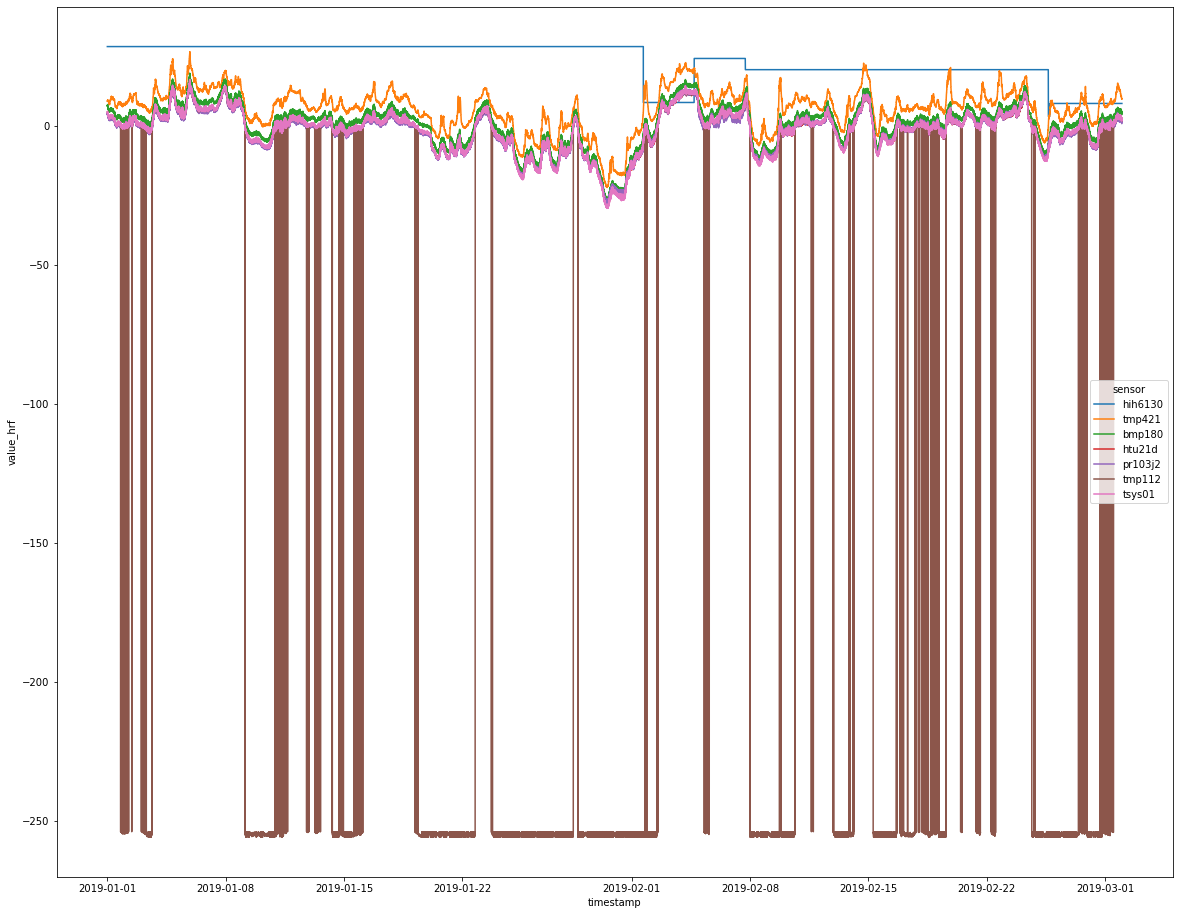

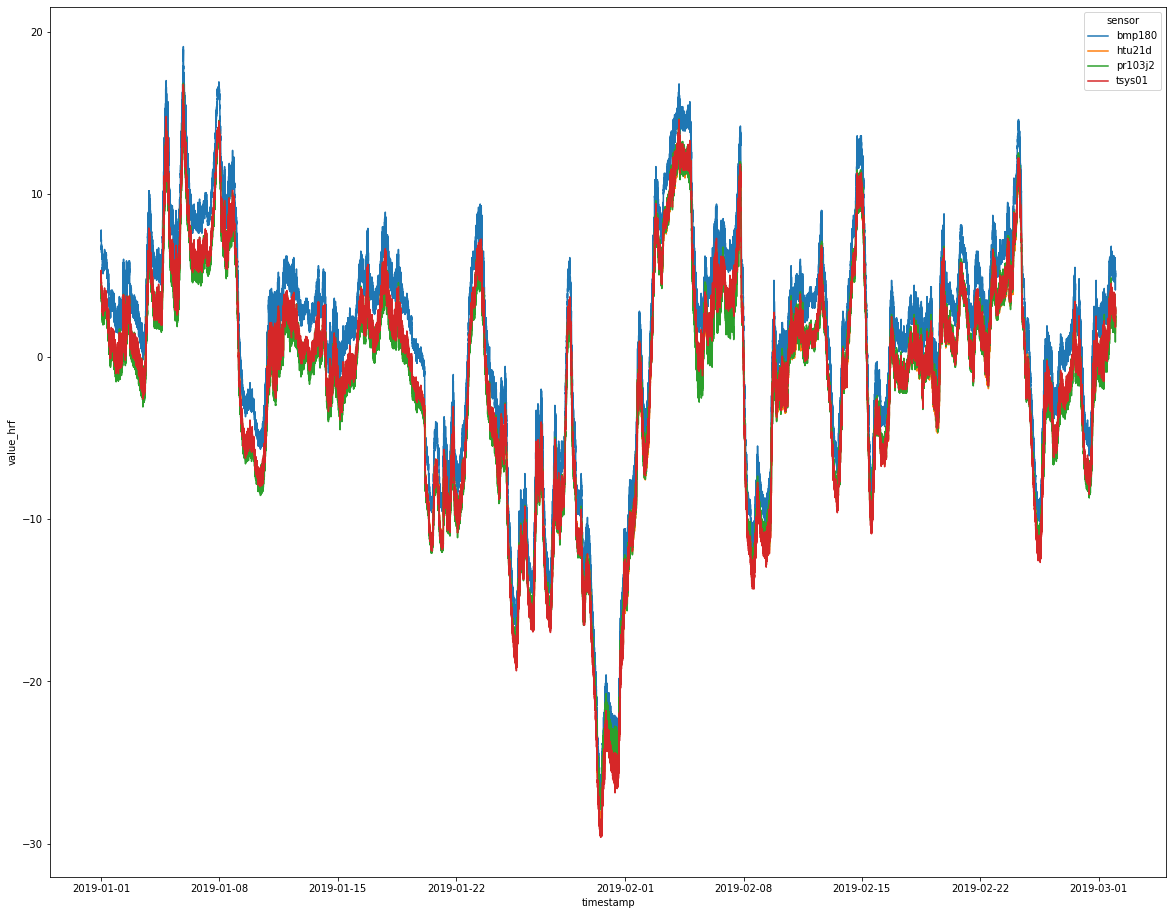

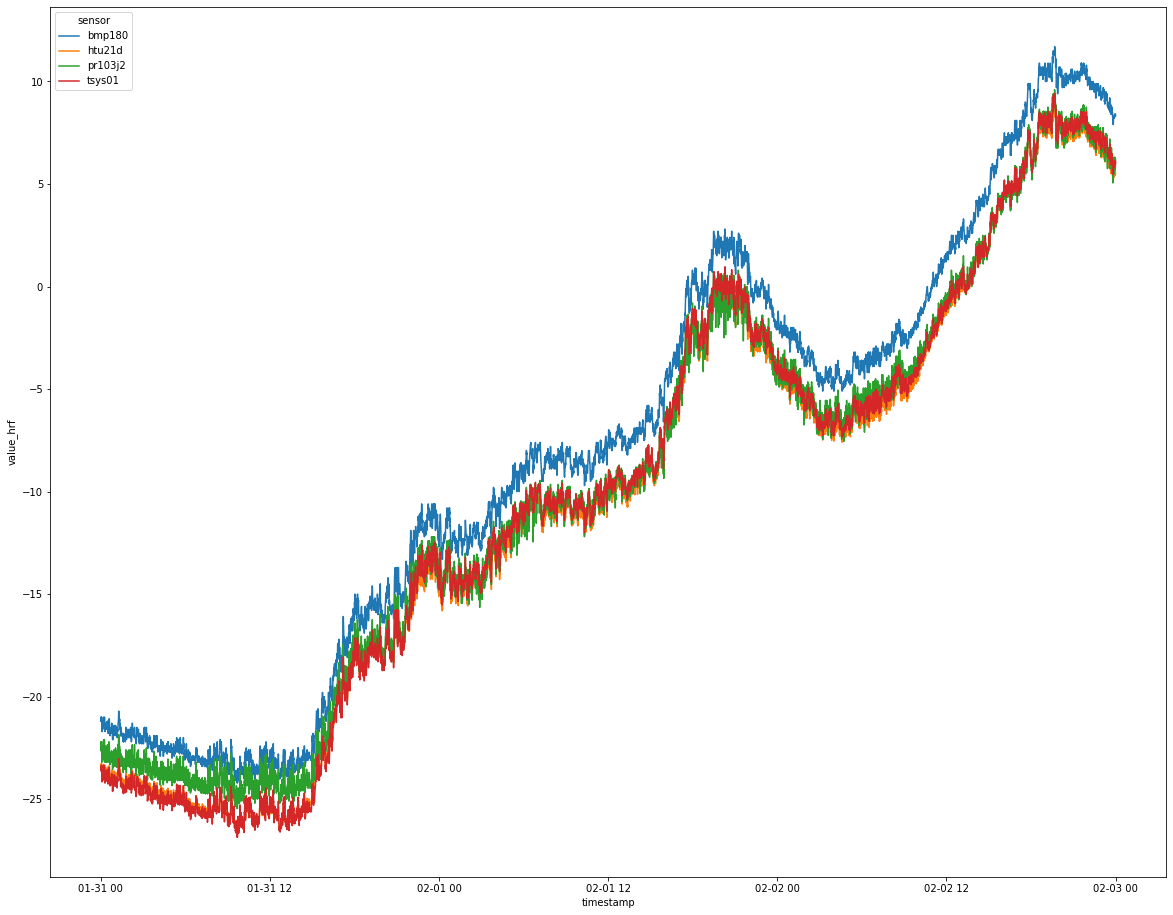

In [ ]:
minidf.head(10)

In [ ]:
len(minidf)

In [ ]:
len(tdf)

In [ ]:
non_tdf = minidf[minidf.parameter != 'temperature'].copy()

In [ ]:
len(non_tdf)

In [ ]:
for p in non_tdf.parameter.unique(): print(p)

In [ ]:

# non_tdf.head(1000)


In [ ]:

# i dont think we necessariry care too much about acceleration data (although its good to have), but 
# maybe lets focus on 


In [ ]:

hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.head(10)

# three sep datavalues ! 


In [ ]:

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:
hdf.dtypes

In [ ]:

hdf = hdf[hdf['sensor'].isin(['hih4030'])]
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:

hdf.value_hrf = hdf.value_hrf.astype(np.float16)
hdf = hdf.loc['2019-02-01 03:00':'2019-02-01 04:00'].copy()
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()



In [ ]:

hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['hih4030', 'htu21d'])]

hdf = hdf.loc['2019-02-01':'2019-02-12'].copy()
# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:

minidf = df.loc['2019-01-01':'2019-06-01'].copy()
hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['htu21d'])]
# hdf = hdf.loc['2019-02-01':'2020-02-01'].copy()

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:

minidf = df.loc['2019-01-01':'2019-06-01'].copy()
hdf = minidf[minidf.parameter == 'humidity'].copy()
hdf.value_hrf = hdf.value_hrf.astype(np.float16)

hdf = hdf[hdf['sensor'].isin(['hih4030'])]
# hdf = hdf.loc['2019-02-01':'2020-02-01'].copy()

# Sets the figure size temporarily but has to be set again the next plot
plt.figure(figsize=(20,16))
sns.lineplot(x=hdf.index, y="value_hrf", hue="sensor", data=hdf); 
plt.show()


In [ ]:
# make large numbers more readable by adding commas
# pd.options.display.float_format = '{:,}'.format
# Example
# 123456789.12345 -> 123,456,789.12345



In [ ]:
# from sklearn.cluster import DBSCAN
# clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(ts_dataframe['Normalized Profit']).reshape(-1,1))
# labels = clustering1.labels_
# outlier_pos = np.where(labels == -1)[0]
# x = []; y = [];
# for pos in outlier_pos:
#     x.append(np.array(ts_dataframe['Normalized Profit'])[pos])
#     y.append(ts_dataframe['Normalized Profit'].index[pos])
    
# plt.plot(ts_dataframe['Normalized Profit'].loc[ts_dataframe['Normalized Profit'].index], 'k-')
# plt.plot(y,x,'r*', markersize=8)  
# plt.legend(['Actual', 'Anomaly Detected'])
# plt.xlabel('Time Period')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
# plt.ylabel('Normalized Profit')

In [ ]:
# this time, i WONT use the standard scaler, just to see what we see...

#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

from sklearn.cluster import DBSCAN

#   eps=0.2, min_samples=8

#  The argument 'eps' is the distance between two samples to be considered as a neighborhood and 
#  'min_samples' is the number of samples in a neighborhood

####################################################################
db = DBSCAN(eps=0.1, min_samples=10, metric='euclidean', n_jobs=-1)
####################################################################

# X = StandardScaler().fit_transform(X)
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)

db = db.fit(np.array(tsys['value_hrf']).reshape(-1, 1))  # i think smarter to do to_frame() instead... 
                  

In [ ]:
db.get_params(deep=True)

In [ ]:

label=db.labels_

from sklearn import metrics

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[db.core_sample_indices_]=True

# Calculating the number of clusters

n_clusters=len(set(label))- (1 if -1 in label else 0)

print('\nNo of clusters:',n_clusters, '\n\n')

# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')

tsys["cluster"] = db.labels_

print(tsys["cluster"].value_counts(), '\n')

#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()


``` 
RESULTS:
========    

db = DBSCAN(eps=0.03, min_samples=6, metric='euclidean', n_jobs=-1)
 0    139811
 3      4950
 2        37
 1        26
-1        19
 4        10


db = DBSCAN(eps=0.04, min_samples=5, metric='euclidean', n_jobs=-1)
 0    144840
-1        13


db = DBSCAN(eps=0.04, min_samples=7, metric='euclidean', n_jobs=-1)
 0    139848
 1      4989
-1        16


db = DBSCAN(eps=0.04, min_samples=7, metric='euclidean', n_jobs=-1)
 0    139848
 1      4989
-1        16


db = DBSCAN(eps=0.1, min_samples=10, metric='euclidean', n_jobs=-1)
 0    198364
 4      4990
 1        66
-1        41
 2        10
 3        10
 



`````

In [ ]:

# much smaller time range now !!!!!!!

plt.figure(figsize=(25, 6))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# , 'k.', markersize=8)  
plt.legend(['Temp'])
# plt.xlabel('timestamp')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Temperature F°')
plt.box(False)
plt.show();


In [ ]:
tsys.head(10)

In [ ]:

#  0    139839
#  1      4987
# -1        18
#  2         9
    
# No of clusters: 3 
#  0    139839
#  1      4987
# -1        18
#  2         9
       
# --- latest --- 
#  0    198364
#  4      4990
#  1        66
# -1        41
#  2        10
#  3        10
# Name: cluster, dtype: int64 
      
plt.style.use('dark_background')

plt.figure(figsize=(25, 7))

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

plt.plot(tsys.index, tsys.value_hrf, 'white', markersize=1, linewidth=.9)

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']


e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluster 2', s=35, alpha=0.7)

# plt.scatter(a, b, color='red', label='Anomaly',s = 200, alpha=0.5)
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=35, alpha=0.7)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)

plt.show();        


### Thus

1. Lowering the eps value causes less and less anomalies to be determined 
1. Increasing the eps value then...

In [ ]:
# this time, i WONT use the standard scaler, just to see what we see...

#  clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(tsys['value_hrf']).
#  reshape(-1,1))  # or you could take pandas series and go to df with to_frame() pandas function 

from sklearn.cluster import DBSCAN

#   eps=0.2, min_samples=8

#  The argument 'eps' is the distance between two samples to be considered as a neighborhood and 
#  'min_samples' is the number of samples in a neighborhood

####################################################################
db = DBSCAN(eps=0.1, min_samples=10, metric='euclidean', n_jobs=-1)
####################################################################

# X = StandardScaler().fit_transform(X)
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)

db = db.fit(np.array(tsys['value_hrf']).reshape(-1, 1))  # i think smarter to do to_frame() instead... 
                  

In [ ]:
db.get_params(deep=True)

In [ ]:

label=db.labels_

from sklearn import metrics

#identifying the points which makes up our core points
sample_cores=np.zeros_like(label,dtype=bool)

sample_cores[db.core_sample_indices_]=True

# Calculating the number of clusters

n_clusters=len(set(label))- (1 if -1 in label else 0)

print('\nNo of clusters:',n_clusters, '\n\n')

# print('\nRemember, in theory 1 cluster actually means one normal cluster and everything else is _noise_')

tsys["cluster"] = db.labels_

print(tsys["cluster"].value_counts(), '\n')

#tsys["cluster"] = db.labels_
# tsys["cluster"].value_counts()


``` 
RESULTS:
========    

db = DBSCAN(eps=0.03, min_samples=6, metric='euclidean', n_jobs=-1)
 0    139811
 3      4950
 2        37
 1        26
-1        19
 4        10


db = DBSCAN(eps=0.04, min_samples=5, metric='euclidean', n_jobs=-1)
 0    144840
-1        13


db = DBSCAN(eps=0.04, min_samples=7, metric='euclidean', n_jobs=-1)
 0    139848
 1      4989
-1        16


db = DBSCAN(eps=0.04, min_samples=7, metric='euclidean', n_jobs=-1)
 0    139848
 1      4989
-1        16


db = DBSCAN(eps=0.1, min_samples=10, metric='euclidean', n_jobs=-1)
 0    198364
 4      4990
 1        66
-1        41
 2        10
 3        10
 



`````

In [ ]:

# much smaller time range now !!!!!!!

plt.figure(figsize=(25, 6))
plt.plot(tsys.index, tsys.value_hrf, 'grey', markersize=1, linewidth=.9)
# , 'k.', markersize=8)  
plt.legend(['Temp'])
# plt.xlabel('timestamp')
# plt.xticks([0, 20, 40, 60, 80, 99],[ts_dataframe.index[0],ts_dataframe.index[20], ts_dataframe.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
plt.ylabel('Temperature F°')
plt.box(False)
plt.show();


In [ ]:

#  0    139839
#  1      4987
# -1        18
#  2         9
    
# No of clusters: 3 
#  0    139839
#  1      4987
# -1        18
#  2         9
       
# --- latest --- 
#  0    198364
#  4      4990
#  1        66
# -1        41
#  2        10
#  3        10
# Name: cluster, dtype: int64 
      
plt.style.use('dark_background')

plt.figure(figsize=(25, 7))

a = tsys.loc[tsys['cluster'] == -1].index
b= tsys[(tsys['cluster'] == -1)]['value_hrf']

plt.plot(tsys.index, tsys.value_hrf, 'white', markersize=1, linewidth=.9)

c = tsys.loc[tsys['cluster'] == 1].index
d= tsys[(tsys['cluster'] == 1)]['value_hrf']


e = tsys.loc[tsys['cluster'] == 2].index
f= tsys[(tsys['cluster'] == 2)]['value_hrf']
plt.scatter(e, f, color='orange', label = 'Anomaly Cluter 2', s=35, alpha=0.7)

# plt.scatter(a, b, color='red', label='Anomaly',s = 200, alpha=0.5)
plt.scatter(a, b, color='red', label = 'Anomaly Cluter -1', s=35, alpha=0.7)
plt.scatter(c, d, color='blue', label = 'Anomaly Cluster 1', s=30, alpha=0.5)

# plt.xlabel('Arrival Date')
plt.ylabel('Temperature C°')
plt.legend()
plt.box(False)

plt.show();        
